In [1]:
%matplotlib inline

import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import harmonypy
from cnmf import cNMF
import seaborn as sns
import yaml
from scipy.stats import pearsonr
from IPython.display import Image
from matplotlib.pyplot import rc_context

sys.path.append('../../../Code/')
from utils import read_dataset_log, match_columns

In [2]:
! pwd

/data/srlab1/TCAT/Analysis/PerDataset/COMBAT


In [3]:
paths ={'Original': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.20231231.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.20231231.RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.20231231.metadata.tsv',
 'Raw_Filt_For_cNMF': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.20231231.FiltForcNMF.h5ad',
 'ADT_MI_Rank': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.20231231.ADT.TP10K.VarNorm.leidenRNA_MI.tsv',
 'ADT_Varnom_Harmony': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.20231231.ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.20231231.RNA_and_ADT.TP10K.h5ad',
 'RNA_and_ADT_HVG_List': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.20231231.RNA_and_ADT.HVGlist.tsv',
 'RNA_and_ADT_Varnorm_Harmony_WNN': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.20231231.RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu',
 'RNA_and_ADT_Varnorm_Harmony': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.20231231.RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'WNN_UMAP': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.20231231.RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv'}

# Run cNMF

In [4]:
cnmfdir = '../../../Data/PerDataset/COMBAT'
name = 'COMBAT.20240107'

In [5]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['RNA_and_ADT_TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.arange(15, 55)
n_iter = 20
num_per_node = 5

In [6]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [10]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [11]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

160

In [12]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J COMBAT.20240107 -o ../../../Data/PerDataset/COMBAT/COMBAT.20240107/log/COMBAT.20240107.0.out.txt -e ../../../Data/PerDataset/COMBAT/COMBAT.20240107/log/COMBAT.20240107.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name COMBAT.20240107 --output-dir ../../../Data/PerDataset/COMBAT --total-workers 160 --worker-index 0"
Job <127078> is submitted to queue <short>.
bsub -q short -J COMBAT.20240107 -o ../../../Data/PerDataset/COMBAT/COMBAT.20240107/log/COMBAT.20240107.1.out.txt -e ../../../Data/PerDataset/COMBAT/COMBAT.20240107/log/COMBAT.20240107.1.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name COMBAT.202401

In [7]:
! bjobs

No unfinished job found


In [8]:
total_workers = int((len(Ks)*n_iter))
total_workers

800

In [9]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            print(worker_i, outfn)
            missing.append(worker_i)

767 ../../../Data/PerDataset/COMBAT/COMBAT.20240107/cnmf_tmp/COMBAT.20240107.spectra.k_53.iter_7.df.npz
790 ../../../Data/PerDataset/COMBAT/COMBAT.20240107/cnmf_tmp/COMBAT.20240107.spectra.k_54.iter_10.df.npz


In [10]:
len(missing)

2

In [11]:
! bjobs | wc -l

No unfinished job found
0


In [12]:
! bjobs

No unfinished job found


In [13]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'medium'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in missing:
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q medium -J COMBAT.20240107 -o ../../../Data/PerDataset/COMBAT/COMBAT.20240107/log/COMBAT.20240107.767.out.txt -e ../../../Data/PerDataset/COMBAT/COMBAT.20240107/log/COMBAT.20240107.767.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name COMBAT.20240107 --output-dir ../../../Data/PerDataset/COMBAT --total-workers 800 --worker-index 767"
Job <137785> is submitted to queue <medium>.
bsub -q medium -J COMBAT.20240107 -o ../../../Data/PerDataset/COMBAT/COMBAT.20240107/log/COMBAT.20240107.790.out.txt -e ../../../Data/PerDataset/COMBAT/COMBAT.20240107/log/COMBAT.20240107.790.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name 

In [14]:
! bjobs

JOBID   USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
137785  dk718   RUN   medium     cn047       cn044       *.20240107 Jan 11 17:32
137791  dk718   RUN   medium     cn047       cn045       *.20240107 Jan 11 17:32


In [122]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=15.
Combining factorizations for k=16.
Combining factorizations for k=17.
Combining factorizations for k=18.
Combining factorizations for k=19.
Combining factorizations for k=20.
Combining factorizations for k=21.
Combining factorizations for k=22.
Combining factorizations for k=23.
Combining factorizations for k=24.
Combining factorizations for k=25.
Combining factorizations for k=26.
Combining factorizations for k=27.
Combining factorizations for k=28.
Combining factorizations for k=29.
Combining factorizations for k=30.
Combining factorizations for k=31.
Combining factorizations for k=32.
Combining factorizations for k=33.
Combining factorizations for k=34.
Combining factorizations for k=35.
Combining factorizations for k=36.
Combining factorizations for k=37.
Combining factorizations for k=38.
Combining factorizations for k=39.
Combining factorizations for k=40.
Combining factorizations for k=41.
Combining factorizations for k=42.
Combining factorizat

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
CPU times: user 6h 38min 13s, sys: 2h 58min 24s, total: 9h 36min 38s
Wall time: 41min 13s


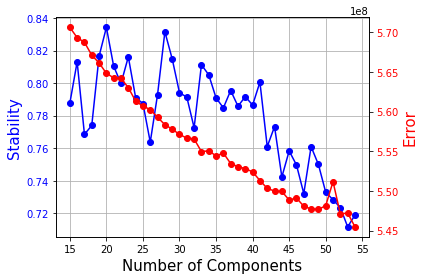

In [123]:
%%time
cnmf_obj.k_selection_plot()

In [17]:
kthresh = {33:.15, 37:.15, 39:.15, 41: .23}


In [ ]:
for k in kthresh.keys():
    cnmf_obj.consensus(k=k, density_threshold=kthresh[k])

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [ ]:
k=41
cnmf_obj.consensus(k=k, density_threshold=kthresh[k])

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


33


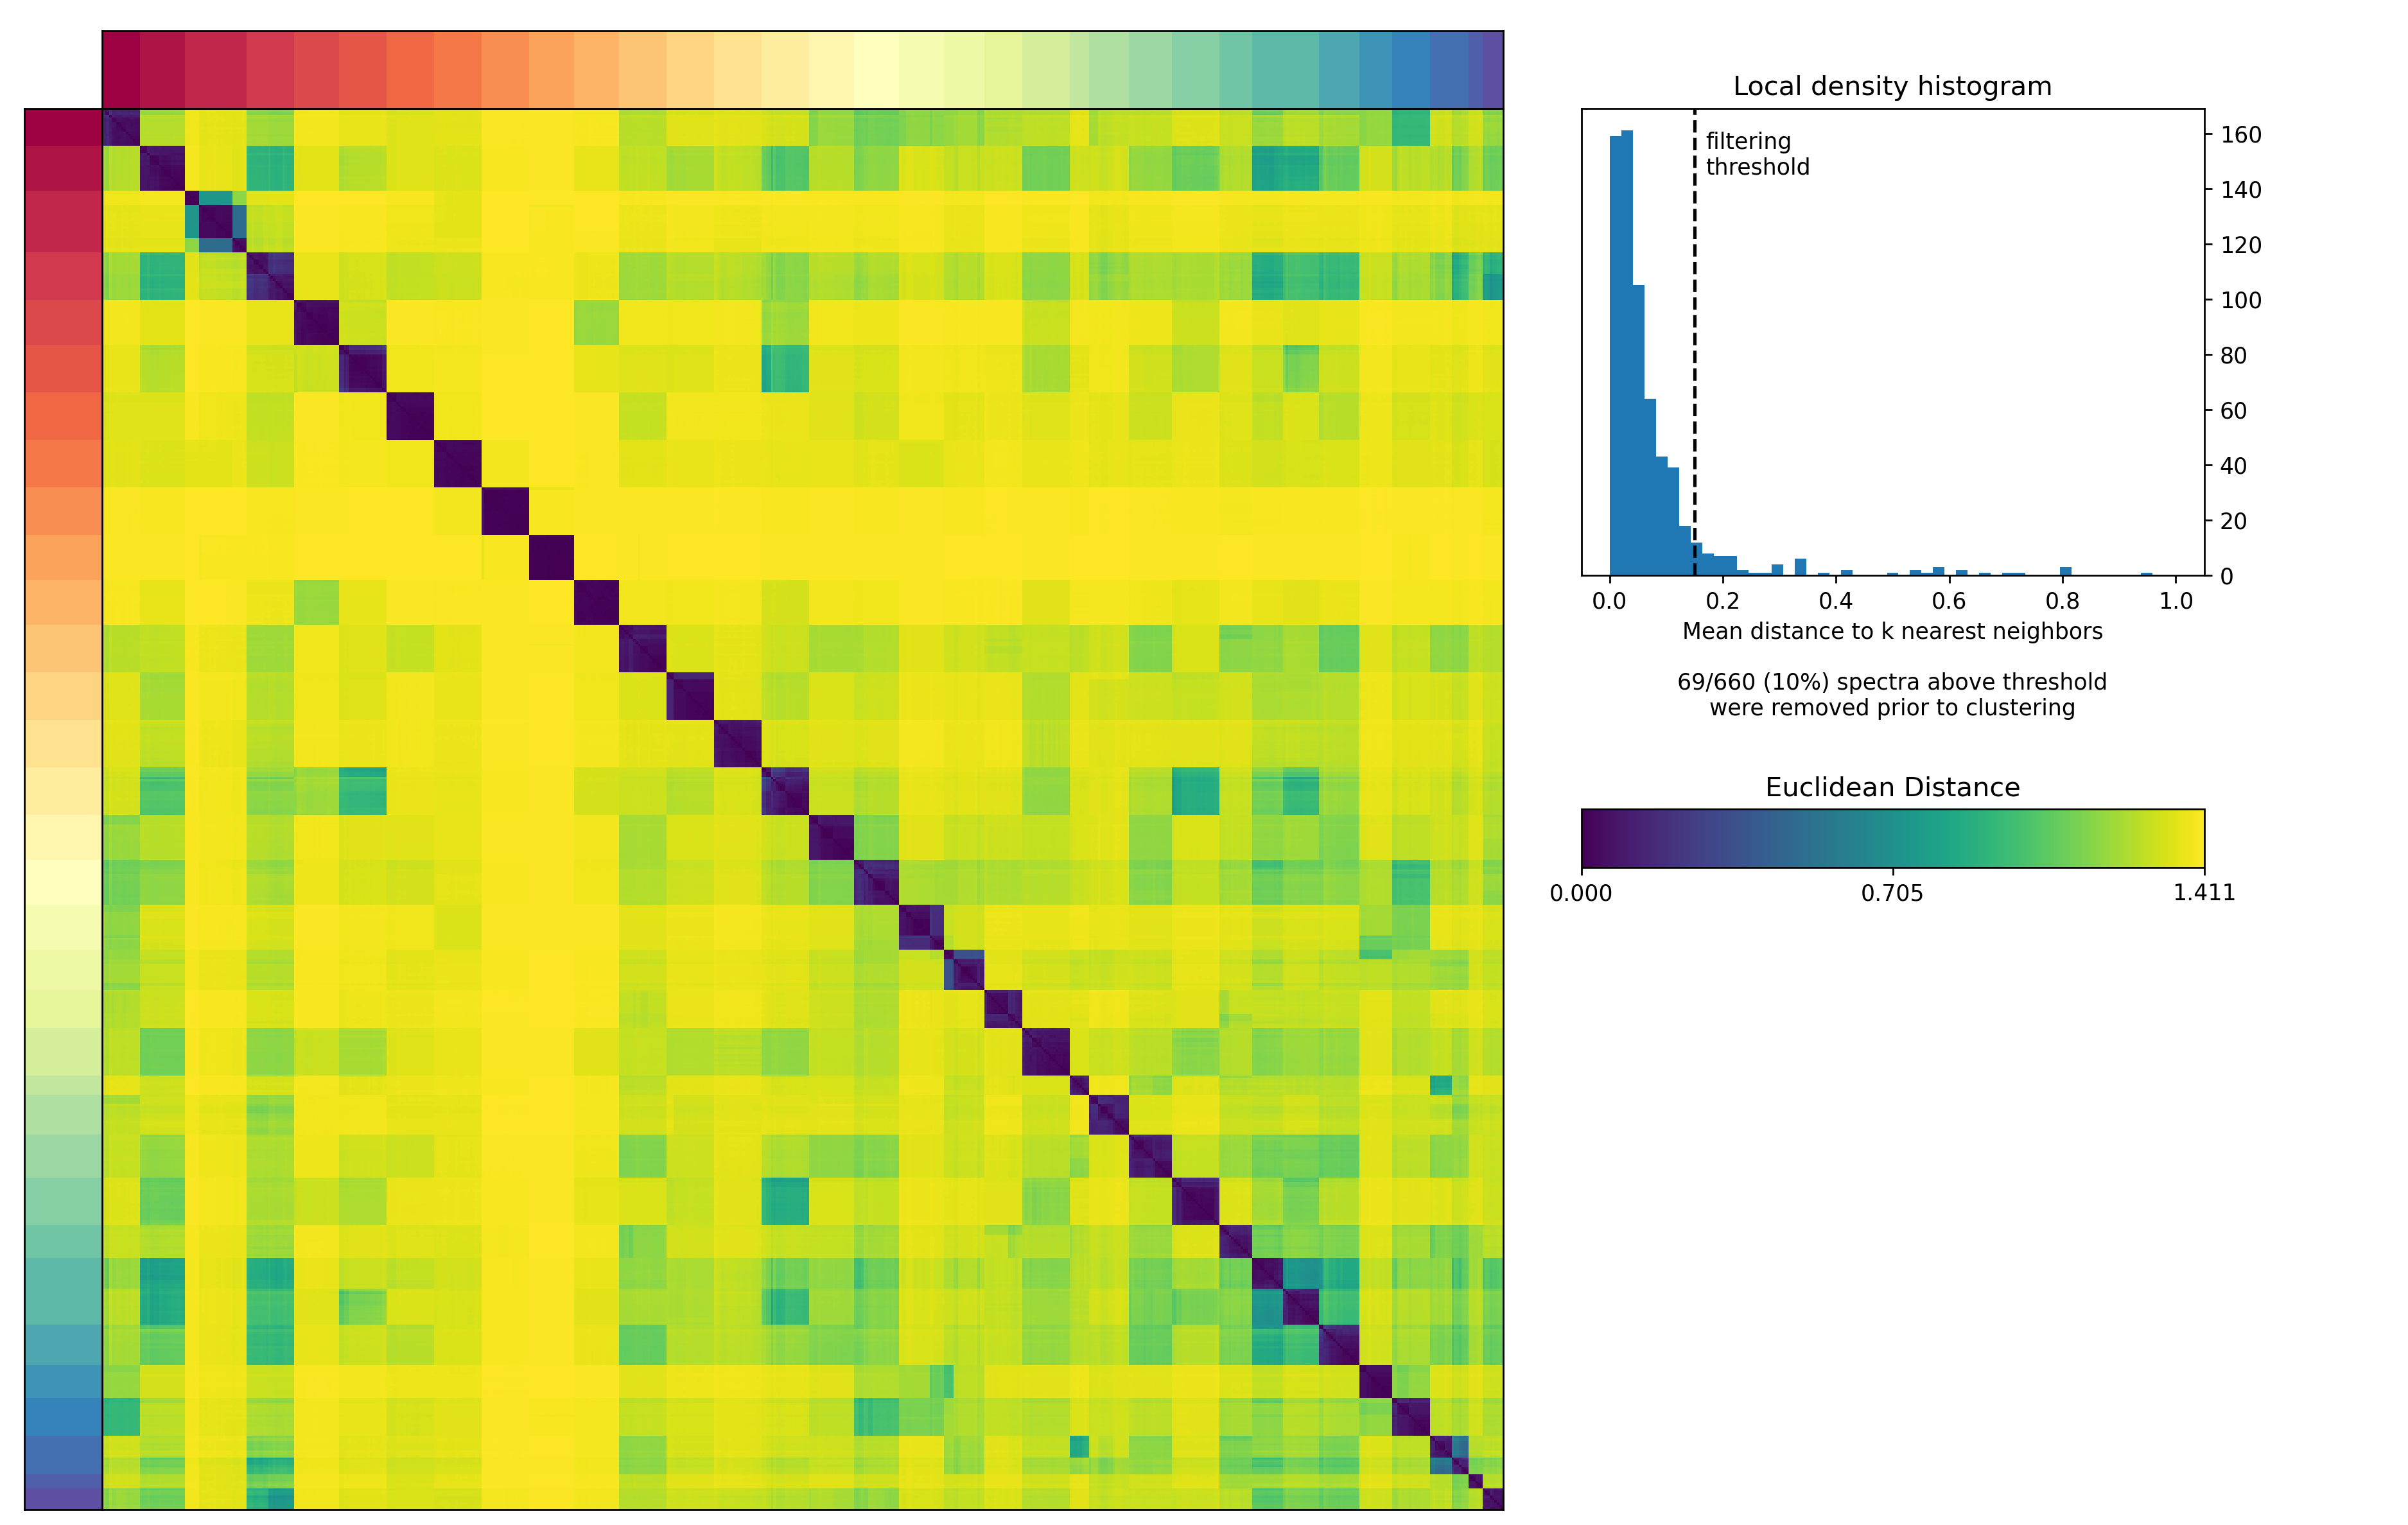

37


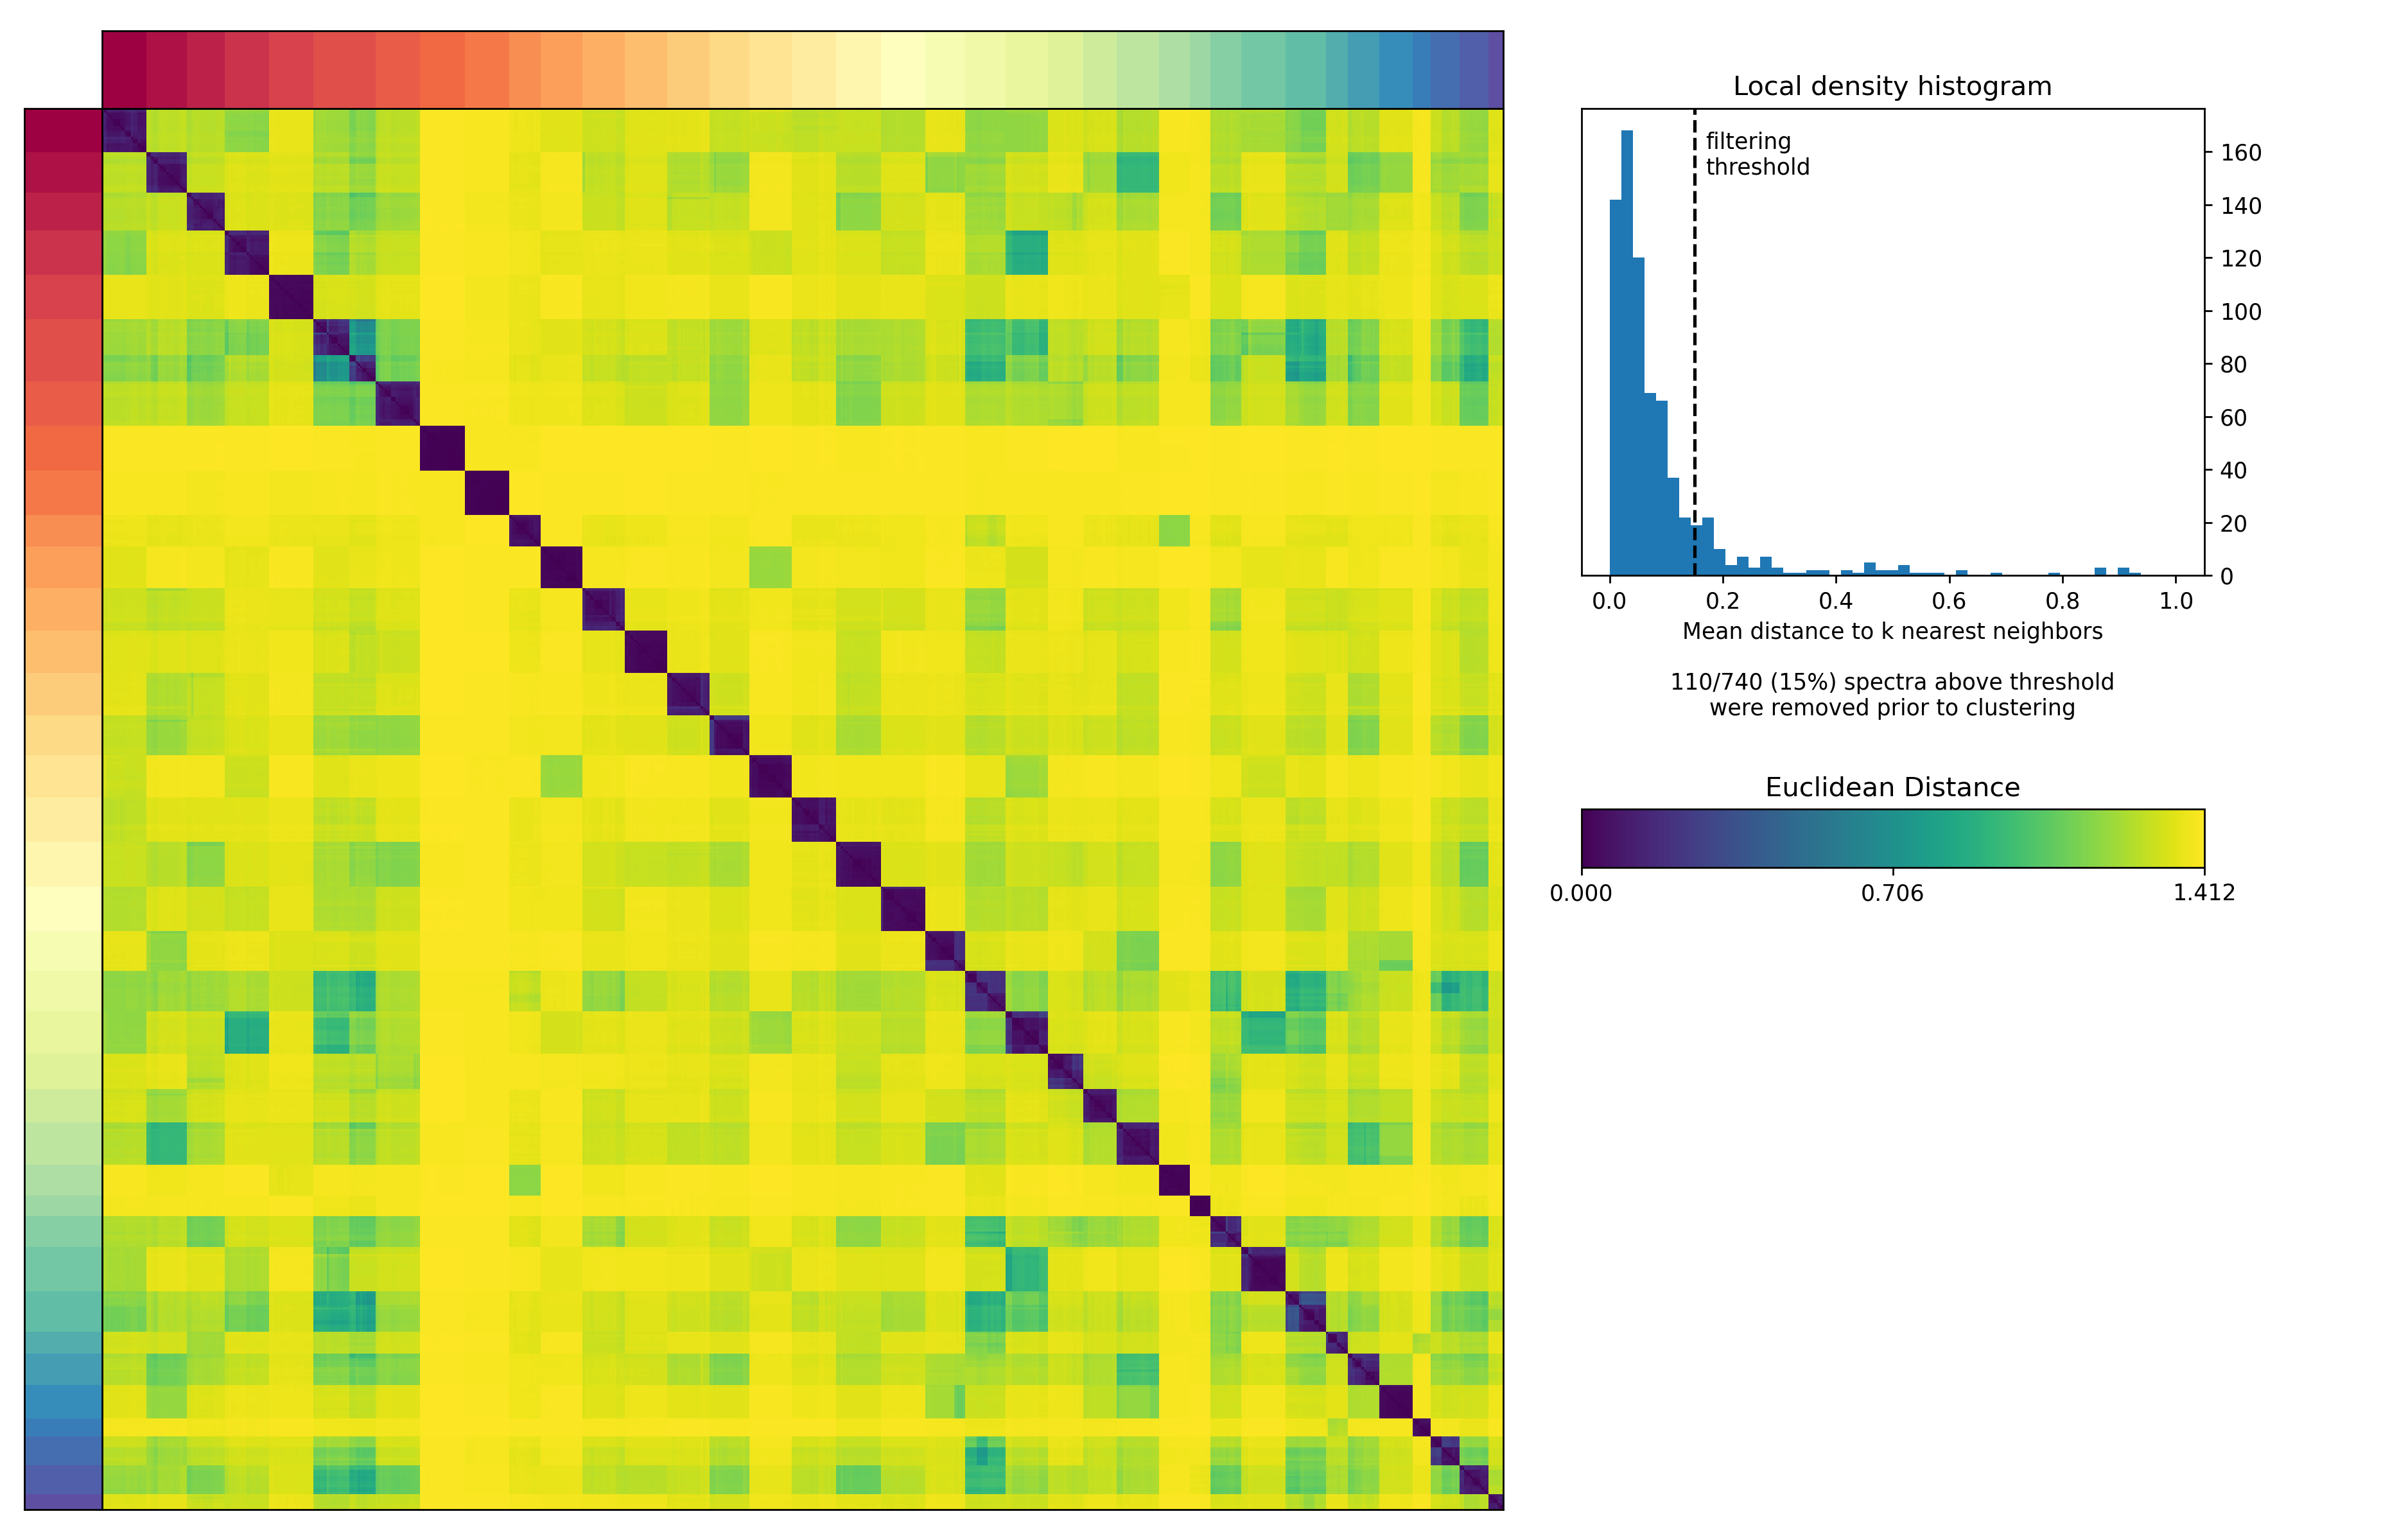

39


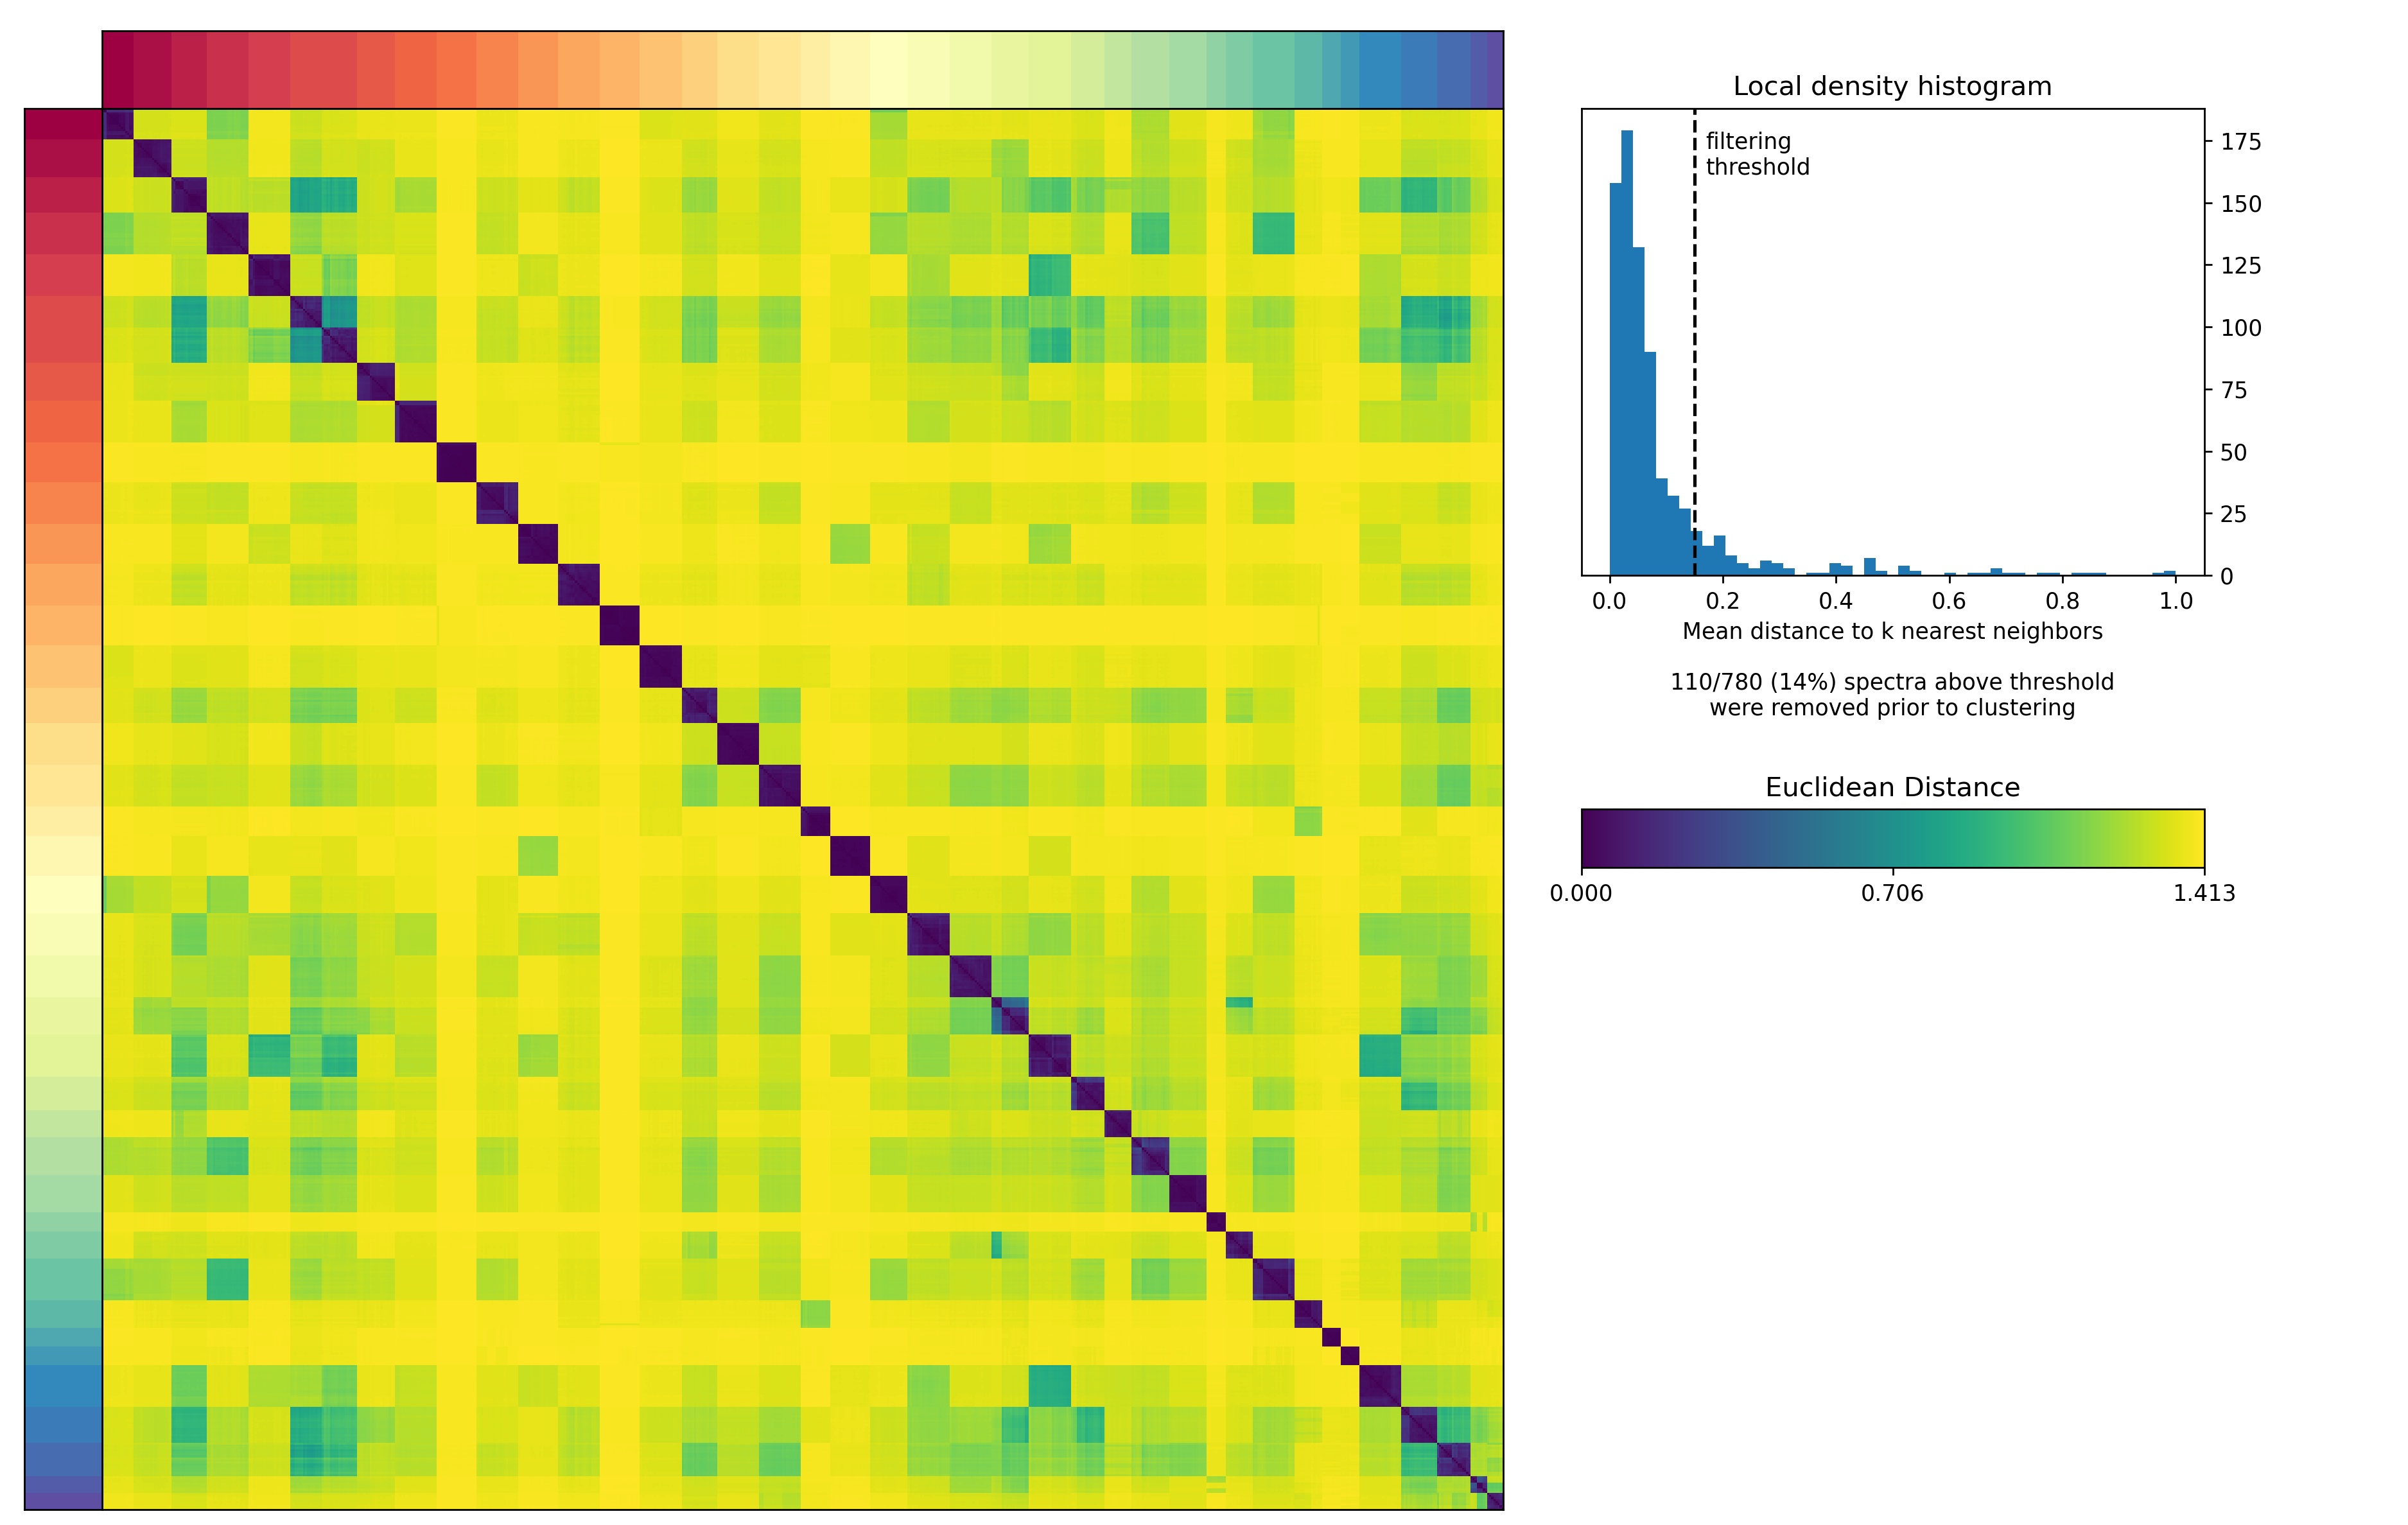

41


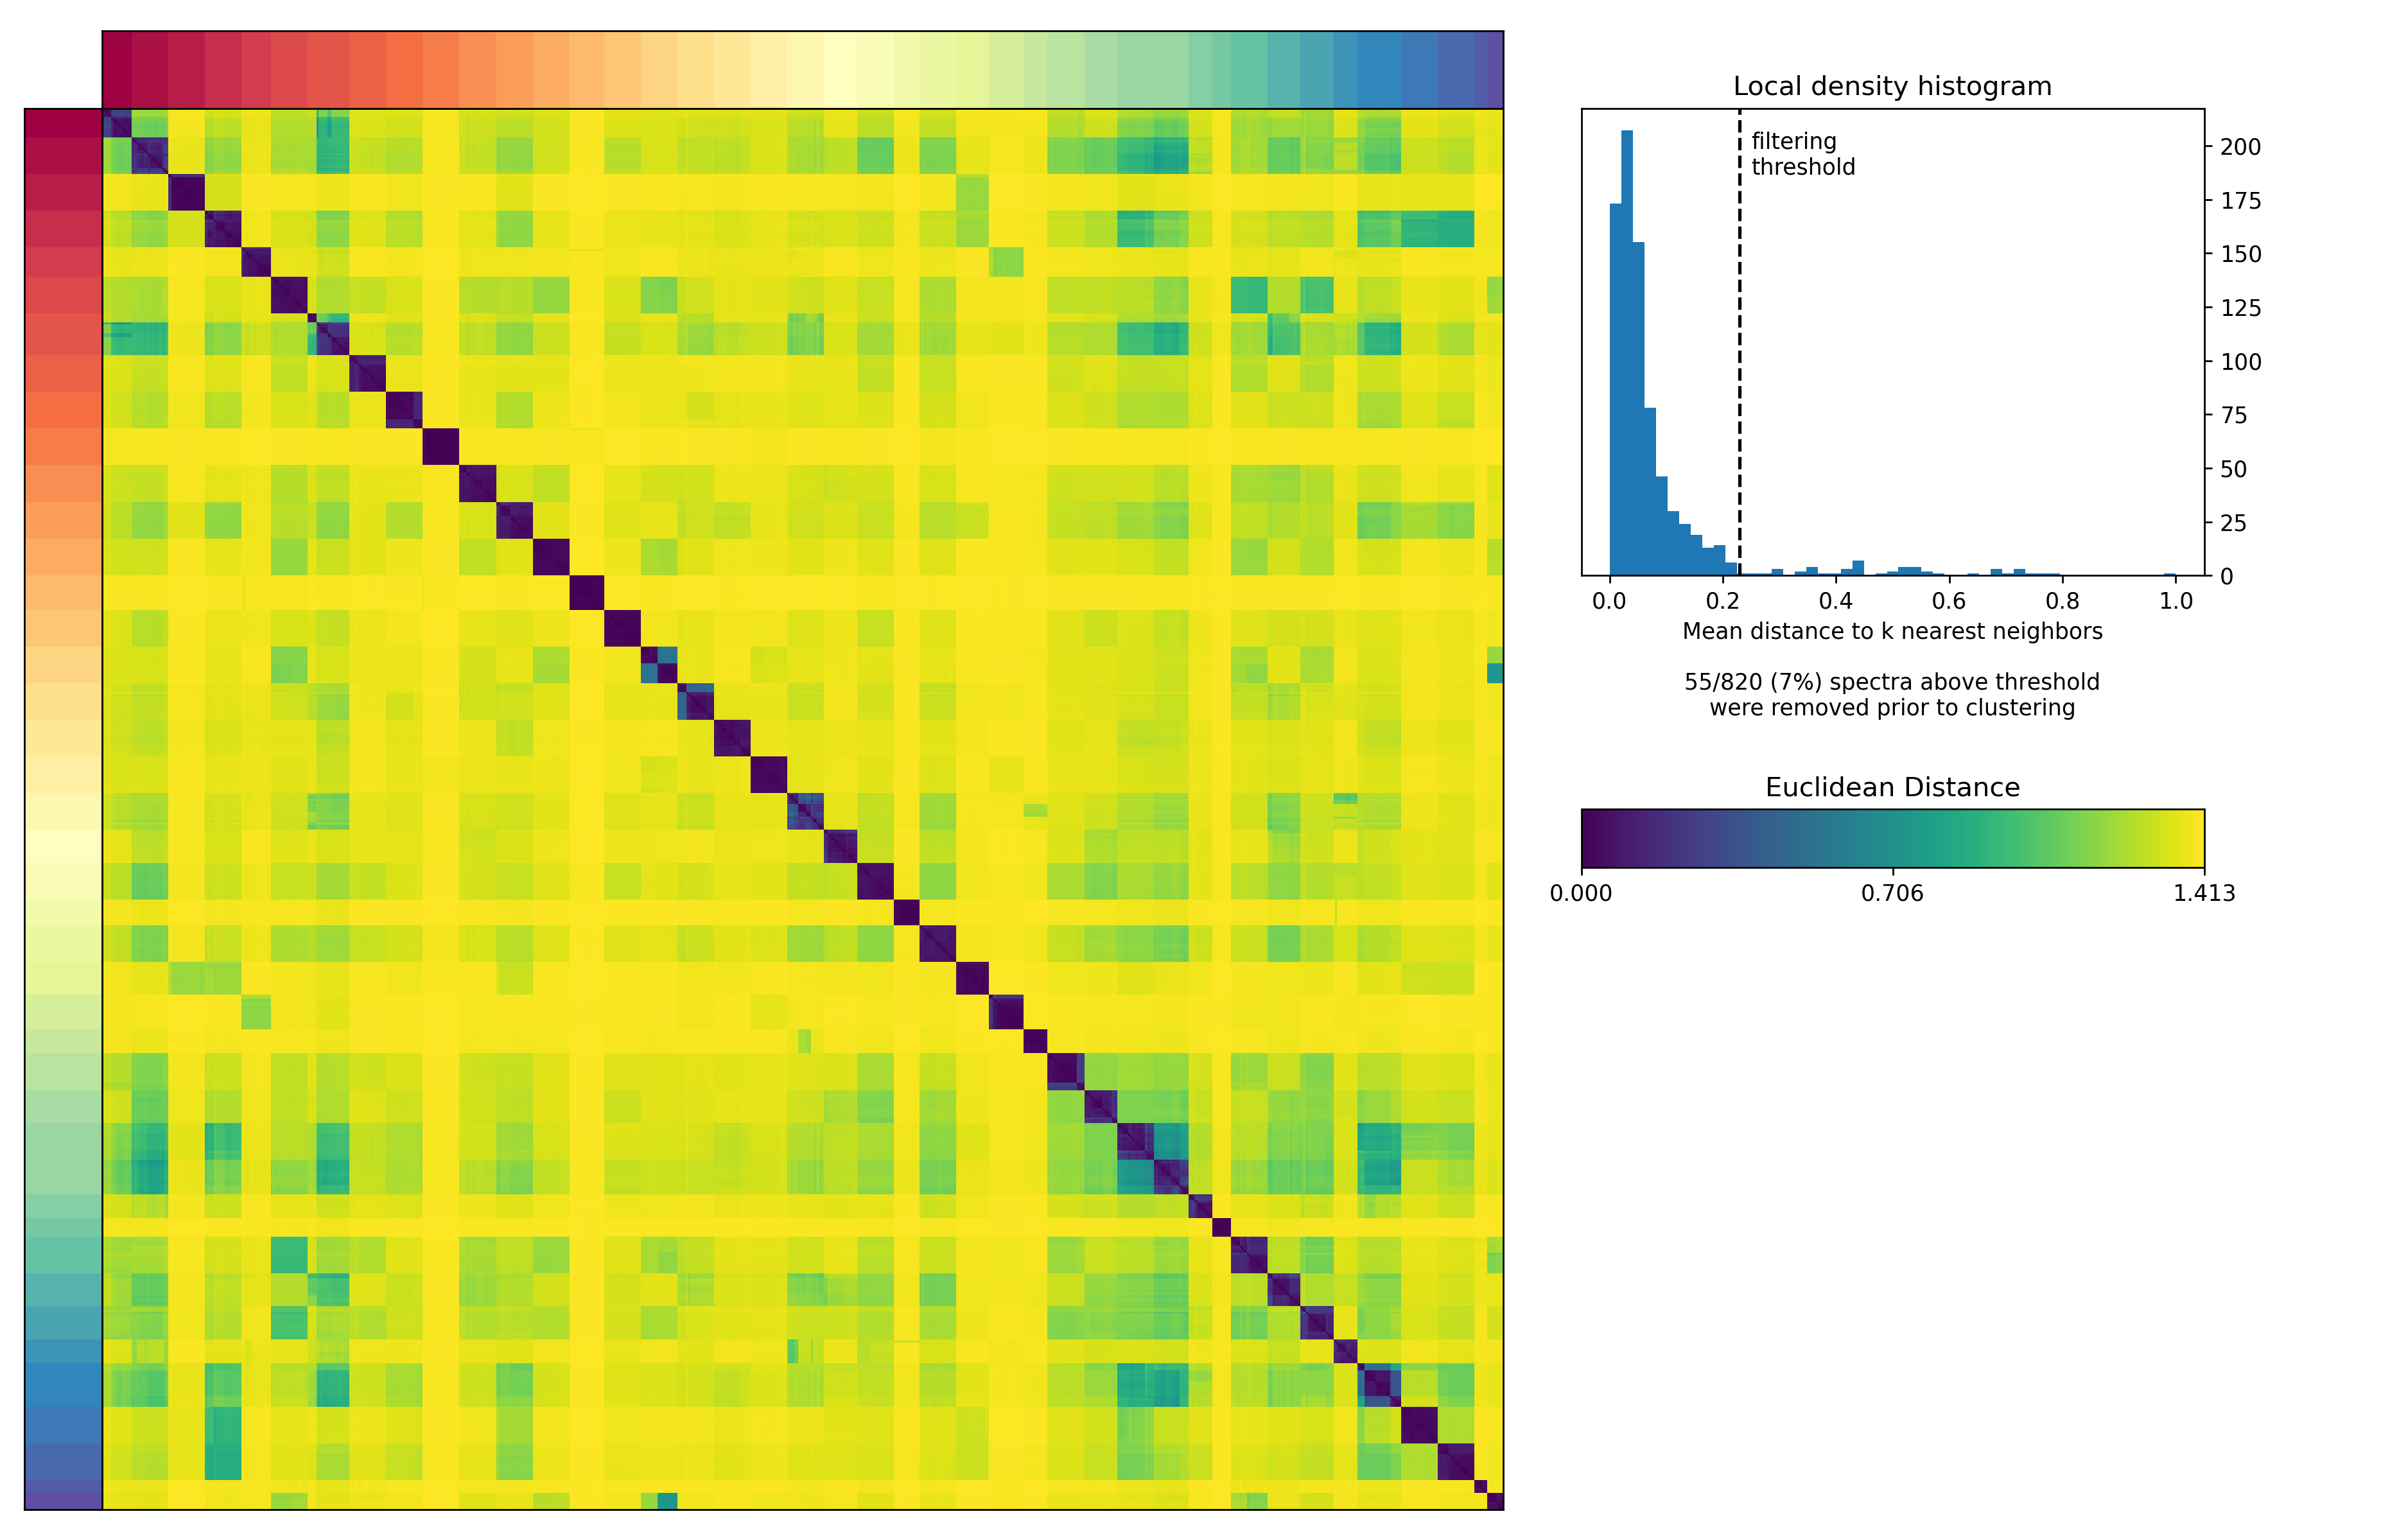

In [19]:
for k in kthresh.keys():
    print(k)
    display(Image(cnmf_obj.paths['clustering_plot'] % (k, str(kthresh[k]).replace('.', '_'))))

## Compare with original TCATs

In [22]:
metagepinfo = read_dataset_log(tabname='cGEP Paths').loc[0,:]
metagepinfo

clustering_fn                                /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
clustering_with_singletons_fn                /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
merged_hvgs                                  /data/srlab1/TCAT/Data/TCAT/MergedHVG_UnionAll...
tpm_varnorm_spectra                          /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_varnorm_spectra_withsingletons           /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_renorm_varnorm_spectra                   /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_renorm_varnorm_spectra_withsingletons    /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra                               /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra_withsingletons                /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
correlation_matrix_tpm_renorm_varnorm        /data/srlab1/TCAT/Data/TCAT/R.TPMrenorm.VarNor...
correlation_matrix_spectra                   /data

In [23]:
clustering = pd.read_csv(metagepinfo.loc['clustering_with_singletons_fn'], sep='\t', index_col=0)
clustering.head()

AMP-RA                TBRU  \
CellCycle-G2M          AMP-RA:CellCycle-G2M  TBRU:CellCycle-G2M   
CD4-Naive_Translation    AMP-RA:Translation    TBRU:Translation   
HLA                              AMP-RA:HLA            TBRU:HLA   
ISG                              AMP-RA:ISG            TBRU:ISG   
MALAT1_Mito                             NaN         TBRU:MALAT1   

                                     UK-Covid                COMBAT  \
CellCycle-G2M          UK-Covid:CellCycle-G2M  COMBAT:CellCycle-G2M   
CD4-Naive_Translation    UK-Covid:Translation      COMBAT:CD4-Naive   
HLA                              UK-Covid:HLA            COMBAT:HLA   
ISG                              UK-Covid:ISG            COMBAT:ISG   
MALAT1_Mito                     UK-Covid:Mito           COMBAT:Mito   

                                     Pan-Cancer                Pan-Tissue  \
CellCycle-G2M          Pan-Cancer:CellCycle-G2M  Pan-Tissue:CellCycle-G2M   
CD4-Naive_Translation                       NaN    Pan-Tissue:Translation   
HLA                              Pan-Cancer:HLA            Pan-Tissue:HLA   
ISG                              Pan-Cancer:ISG            Pan-Tissue:ISG   
MALAT1_Mito                                 NaN           Pan-Tissue:Mito   

                                     HIV-Vaccine  
CellCycle-G2M          HIV-Vaccine:CellCycle-G2M  
CD4-Naive_Translation    HIV-Vaccine:Translation  
HLA                                          NaN  
ISG                              HIV-Vaccine:ISG  
MALAT1_Mito                     HIV-Vaccine:Mito

In [24]:
tcat_spectra_all = pd.read_csv(metagepinfo.loc['scores_spectra'], sep='\t', index_col=0).T

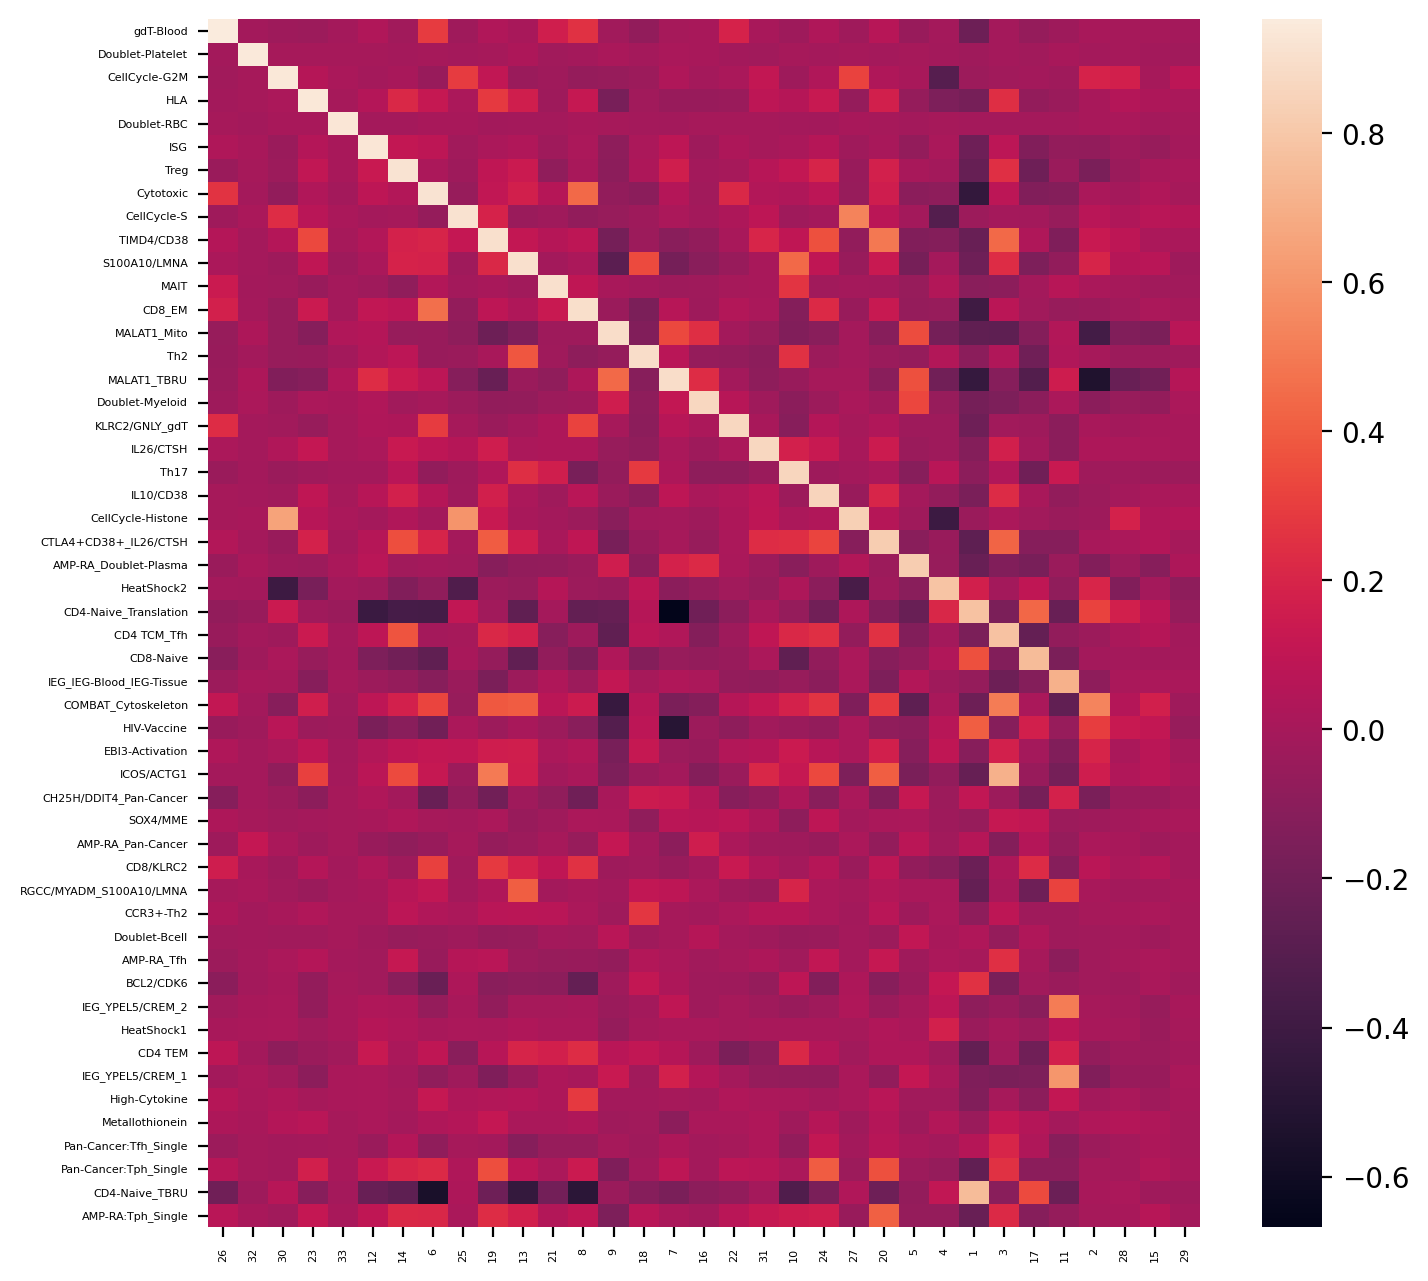

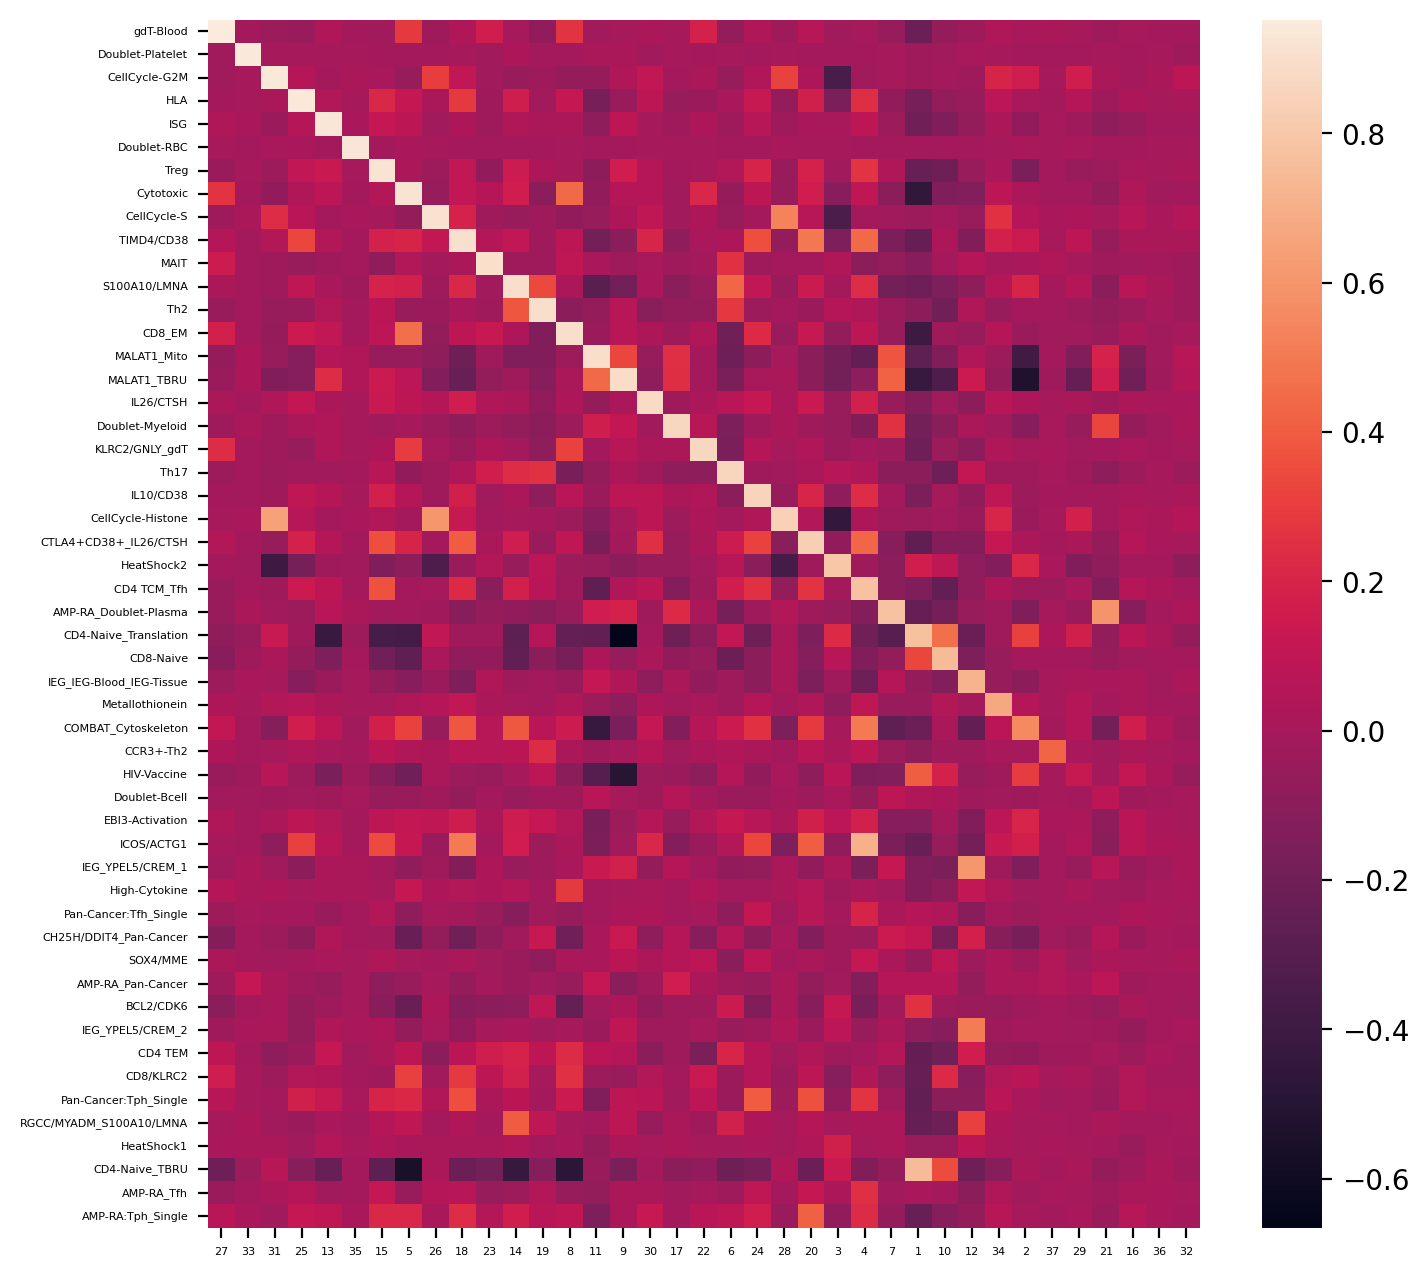

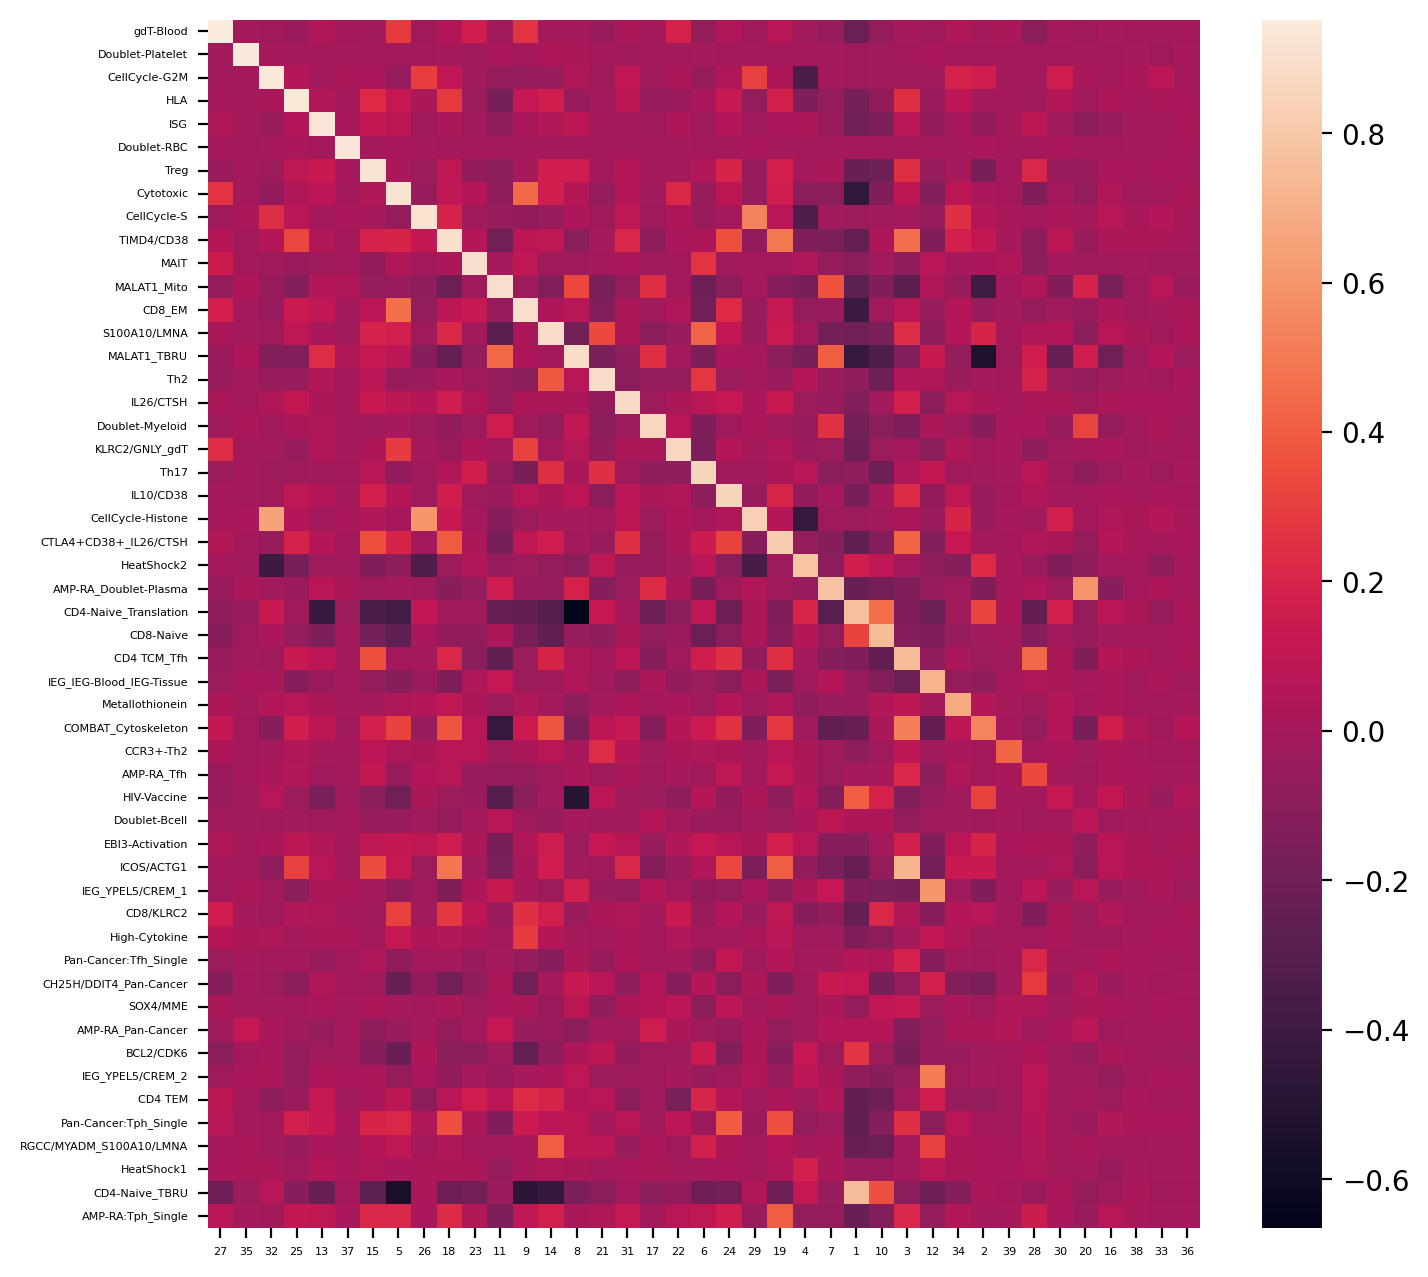

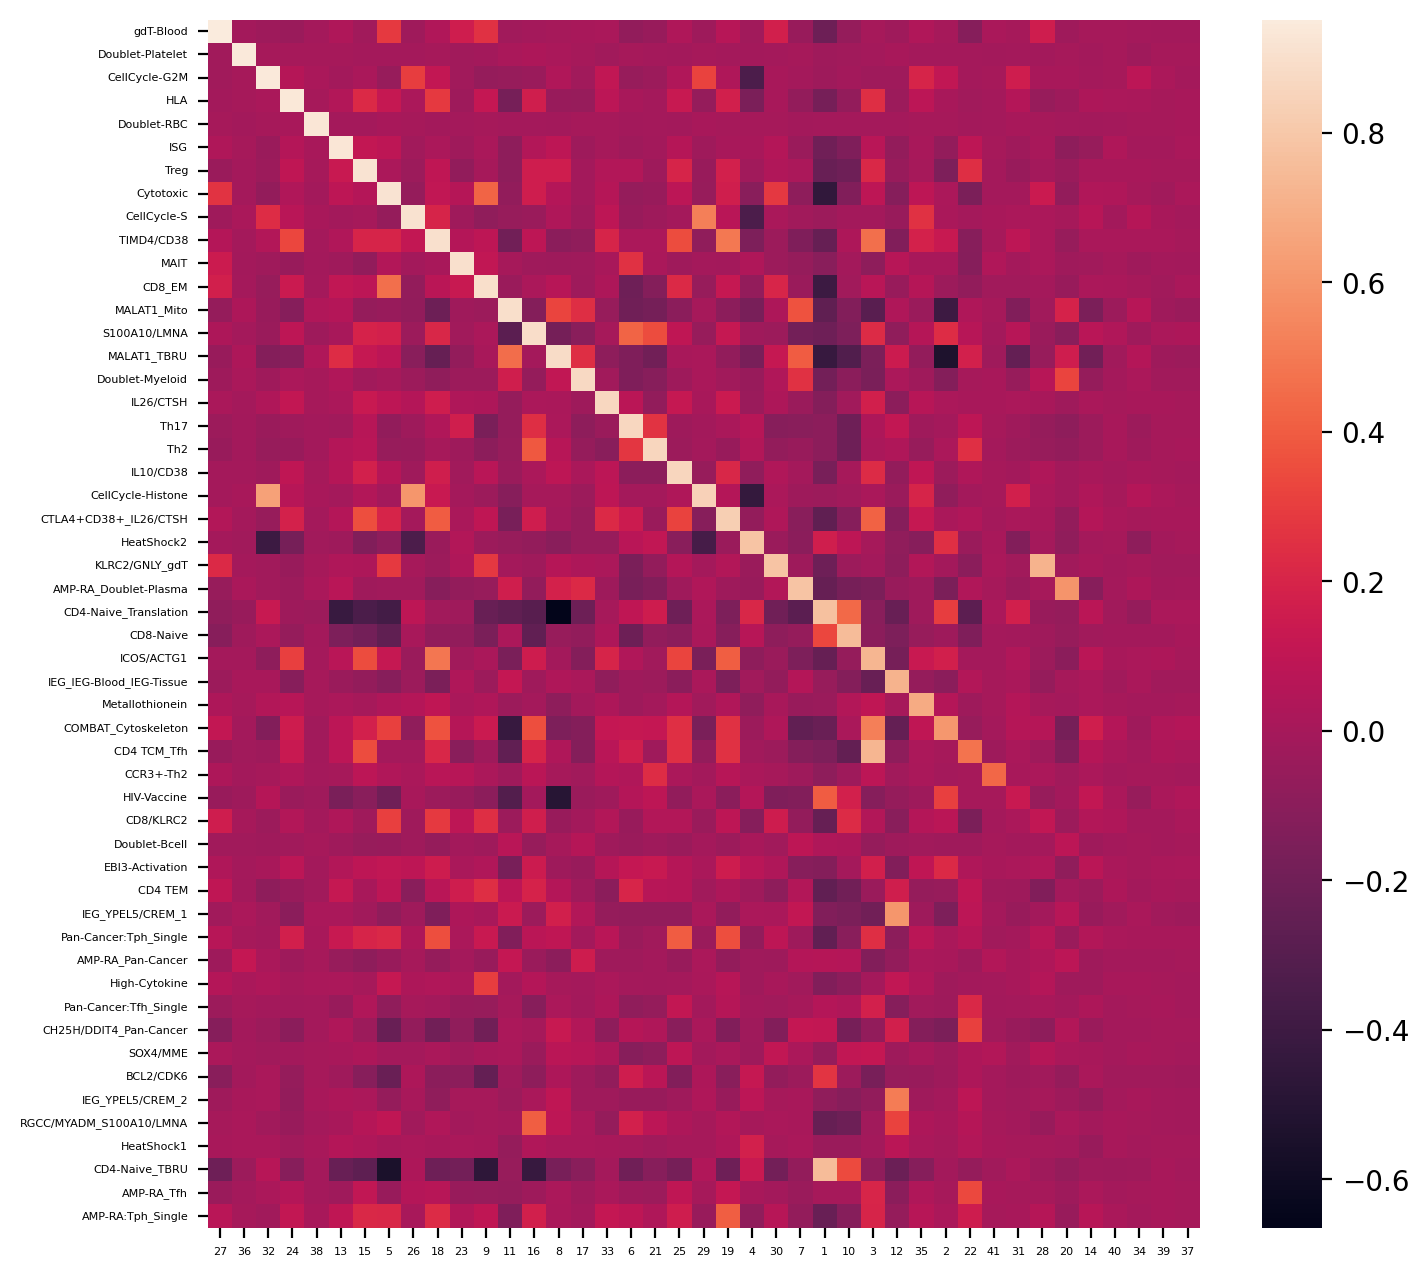

In [25]:
res = []
R_thresh = 0.55
dataset_cols = ['AMP-RA', 'UK-Covid', 'Pan-Tissue', 'HIV-Vaccine', 'COMBAT', 'TBRU', 'Pan-Cancer']
this_datset = 'COMBAT'
other_dataset_cols = list(set(dataset_cols) - set([this_datset]))
mapping_ref = {}
top_genes_relabeled = {}

for k in kthresh.keys():
    (usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=k, density_threshold=kthresh[k])
    overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
    mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
    R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
    rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))
    top_genes = top_genes.rename(columns=rename_dict).loc[:, mapping['X_columns']]
    top_genes_relabeled[k] = top_genes

    fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
    sns.heatmap(R_for_plot, ax=ax)
    ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
    ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
    ax.set_xticklabels(R_for_plot.columns, fontsize=4)
    ax.set_yticklabels(R_for_plot.index, fontsize=4)

    merge_annotation = pd.merge(left=mapping, right=clustering, left_on='X_columns', right_index=True, how='outer')
    mapping_ref[k] = merge_annotation
    total_overlaps = (merge_annotation['R']>R_thresh).sum()
    ind = (merge_annotation['R']>R_thresh) & ((~merge_annotation[dataset_cols].isnull()).sum(axis=1)>1)
    nonsingleton_overlaps = ind.sum()
    this_dataset_singletons_ind = (~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==0
    recur_singleton_ind = this_dataset_singletons_ind & (merge_annotation['R']>R_thresh)
    new_singleton_match_ind = ((~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==1) & (merge_annotation['R']>R_thresh) & merge_annotation[this_datset].isnull()
    res.append([k, total_overlaps, nonsingleton_overlaps, this_dataset_singletons_ind.sum(), recur_singleton_ind.sum(), (merge_annotation['R']<R_thresh).sum(), new_singleton_match_ind.sum()])

    
    
res = pd.DataFrame(res, columns=['K', 'Num_GEP_Overlaps', 'Num_TCAT_NonSingletonOverlaps', 'Orig_TCAT_Dataset_Singletons', 'TCAT_Singletons_Found', 'New_Singletons', 'Orig_TCAT_OtherDataset_Singleton_Match'])


In [26]:
res

K  Num_GEP_Overlaps  Num_TCAT_NonSingletonOverlaps  \
0  33                29                             29   
1  37                31                             31   
2  39                30                             30   
3  41                31                             31   

   Orig_TCAT_Dataset_Singletons  TCAT_Singletons_Found  New_Singletons  \
0                             5                      0               4   
1                             5                      0               6   
2                             5                      0               9   
3                             5                      0              10   

   Orig_TCAT_OtherDataset_Singleton_Match  
0                                       0  
1                                       0  
2                                       0  
3                                       0

In [27]:
set(mapping_ref[37].loc[mapping_ref[37]['R']>R_thresh, 'X_columns']) - set(mapping_ref[33].loc[mapping_ref[33]['R']>R_thresh, 'X_columns'])


{'COMBAT_Cytoskeleton', 'Metallothionein'}

In [33]:
list(set(top_genes_relabeled[41].columns) - set(top_genes_relabeled[33].columns))

['Metallothionein',
 'AMP-RA_Pan-Cancer',
 'CD4 TEM',
 'CD8/KLRC2',
 'Pan-Cancer:Tph_Single',
 'CCR3+-Th2',
 'IEG_YPEL5/CREM_1',
 'Doublet-Bcell']

In [34]:
mapping

Y_columns                 X_columns         R
1358         27                 gdT-Blood  0.951606
1829         36          Doublet-Platelet  0.941136
1612         32             CellCycle-G2M  0.940732
1198         24                       HLA  0.934755
1929         38               Doublet-RBC  0.932654
627          13                       ISG  0.932584
753          15                      Treg  0.919469
216           5                 Cytotoxic  0.919391
1307         26               CellCycle-S  0.913546
914          18                TIMD4/CD38  0.907030
1156         23                      MAIT  0.903457
438           9                    CD8_EM  0.898868
524          11               MALAT1_Mito  0.898159
791          16              S100A10/LMNA  0.892096
391           8               MALAT1_TBRU  0.886021
850          17           Doublet-Myeloid  0.869750
1705         33                 IL26/CTSH  0.867453
286           6                      Th17  0.864149
1075         21                       Th2  0.860345
1281         25                 IL10/CD38  0.857409
1469         29         CellCycle-Histone  0.841426
975          19     CTLA4+CD38+_IL26/CTSH  0.829374
166           4                HeatShock2  0.786249
1525         30            KLRC2/GNLY_gdT  0.785995
343           7     AMP-RA_Doublet-Plasma  0.781345
1             1     CD4-Naive_Translation  0.770399
496          10                 CD8-Naive  0.750771
140           3                ICOS/ACTG1  0.727949
593          12  IEG_IEG-Blood_IEG-Tissue  0.712476
1787         35           Metallothionein  0.686209
66            2       COMBAT_Cytoskeleton  0.605474
1112         22               CD4 TCM_Tfh  0.477037
2114         41                 CCR3+-Th2  0.435456
1604         31               HIV-Vaccine  0.132125
1444         28                 CD8/KLRC2  0.099733
1025         20             Doublet-Bcell  0.084587
719          14           EBI3-Activation  0.076862
2066         40                   CD4 TEM  0.024853
1739         34          IEG_YPEL5/CREM_1  0.013179
2026         39     Pan-Cancer:Tph_Single  0.009765
1918         37         AMP-RA_Pan-Cancer  0.004017

# K=35

In [35]:
cnmfdir = '../../../Data/PerDataset/COMBAT'
name = 'COMBAT.20240111.Iter200'

In [36]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['RNA_and_ADT_TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = [33, 37, 41]
n_iter = 200
num_per_node = 4

In [37]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

150

In [38]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [39]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [43]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'medium'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q medium -J COMBAT.20240111.Iter200 -o ../../../Data/PerDataset/COMBAT/COMBAT.20240111.Iter200/log/COMBAT.20240111.Iter200.0.out.txt -e ../../../Data/PerDataset/COMBAT/COMBAT.20240111.Iter200/log/COMBAT.20240111.Iter200.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name COMBAT.20240111.Iter200 --output-dir ../../../Data/PerDataset/COMBAT --total-workers 150 --worker-index 0"
Job <137835> is submitted to queue <medium>.
bsub -q medium -J COMBAT.20240111.Iter200 -o ../../../Data/PerDataset/COMBAT/COMBAT.20240111.Iter200/log/COMBAT.20240111.Iter200.1.out.txt -e ../../../Data/PerDataset/COMBAT/COMBAT.20240111.Iter200/log/COMBAT.20240111.Iter200.1.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005

In [58]:
! bjobs

No unfinished job found


In [59]:
! bjobs | wc -l

No unfinished job found
0


In [60]:
total_workers = int((len(Ks)*n_iter))
total_workers

600

In [61]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            #print(worker_i, outfn)
            missing.append(worker_i)
            
len(missing)

0

In [62]:
missing

[]

In [63]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'medium'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in missing:
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

## Look at the results for K=35 with 200 iterations

In [67]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=33.
Combining factorizations for k=37.
Combining factorizations for k=41.


In [65]:
kthresh

{33: 0.15, 37: 0.15, 39: 0.15, 41: 0.23}

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


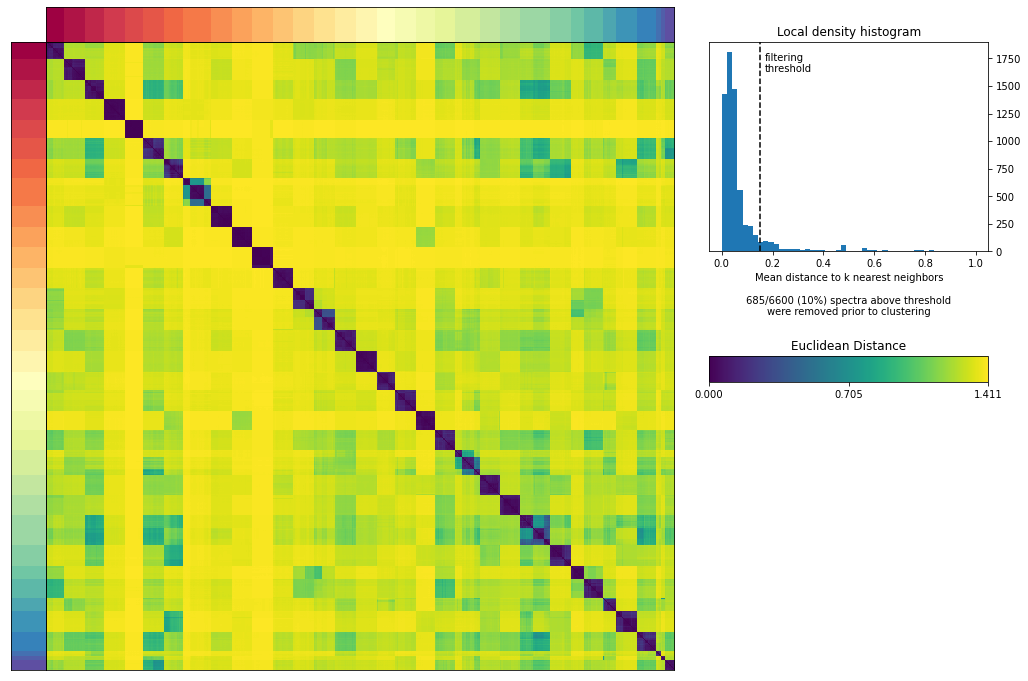

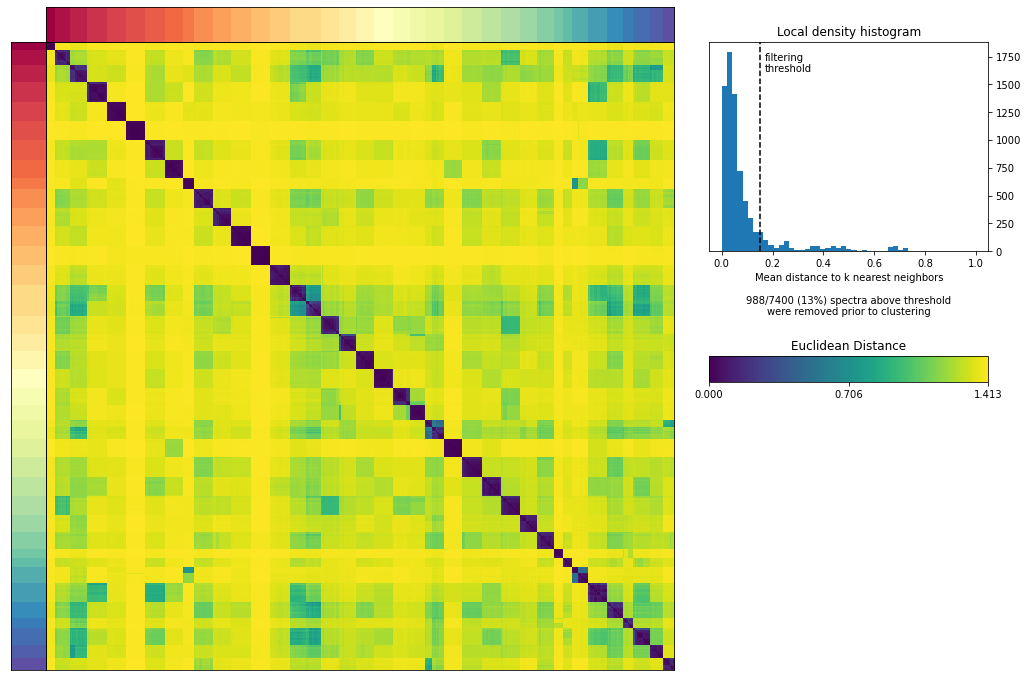

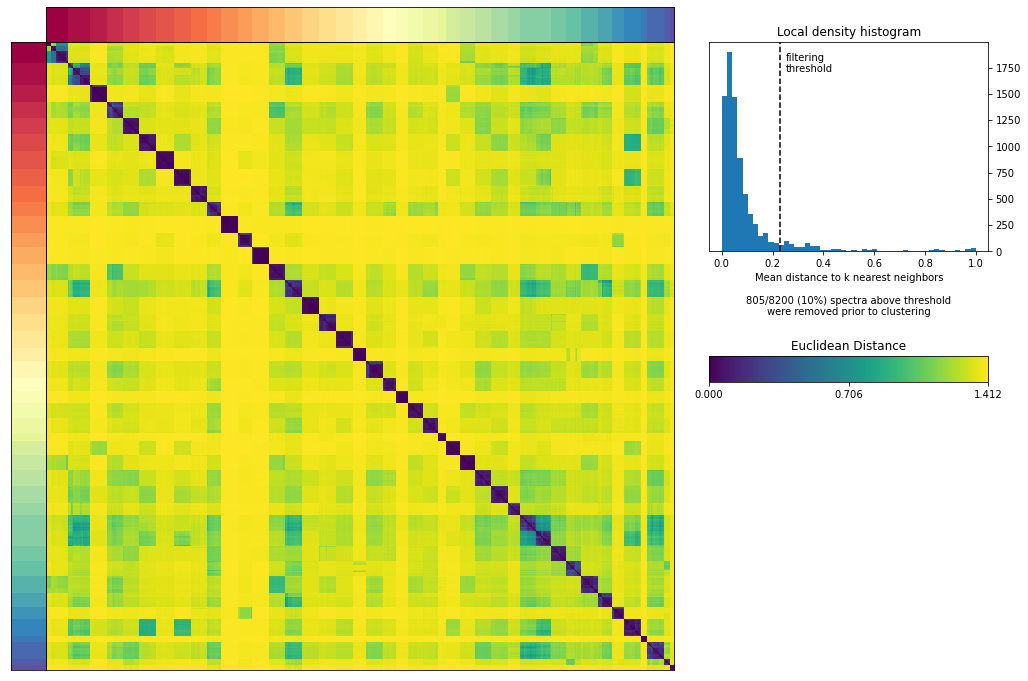

In [68]:
for k in Ks:
    cnmf_obj.consensus(k=k, density_threshold=kthresh[k])

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmfdev_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


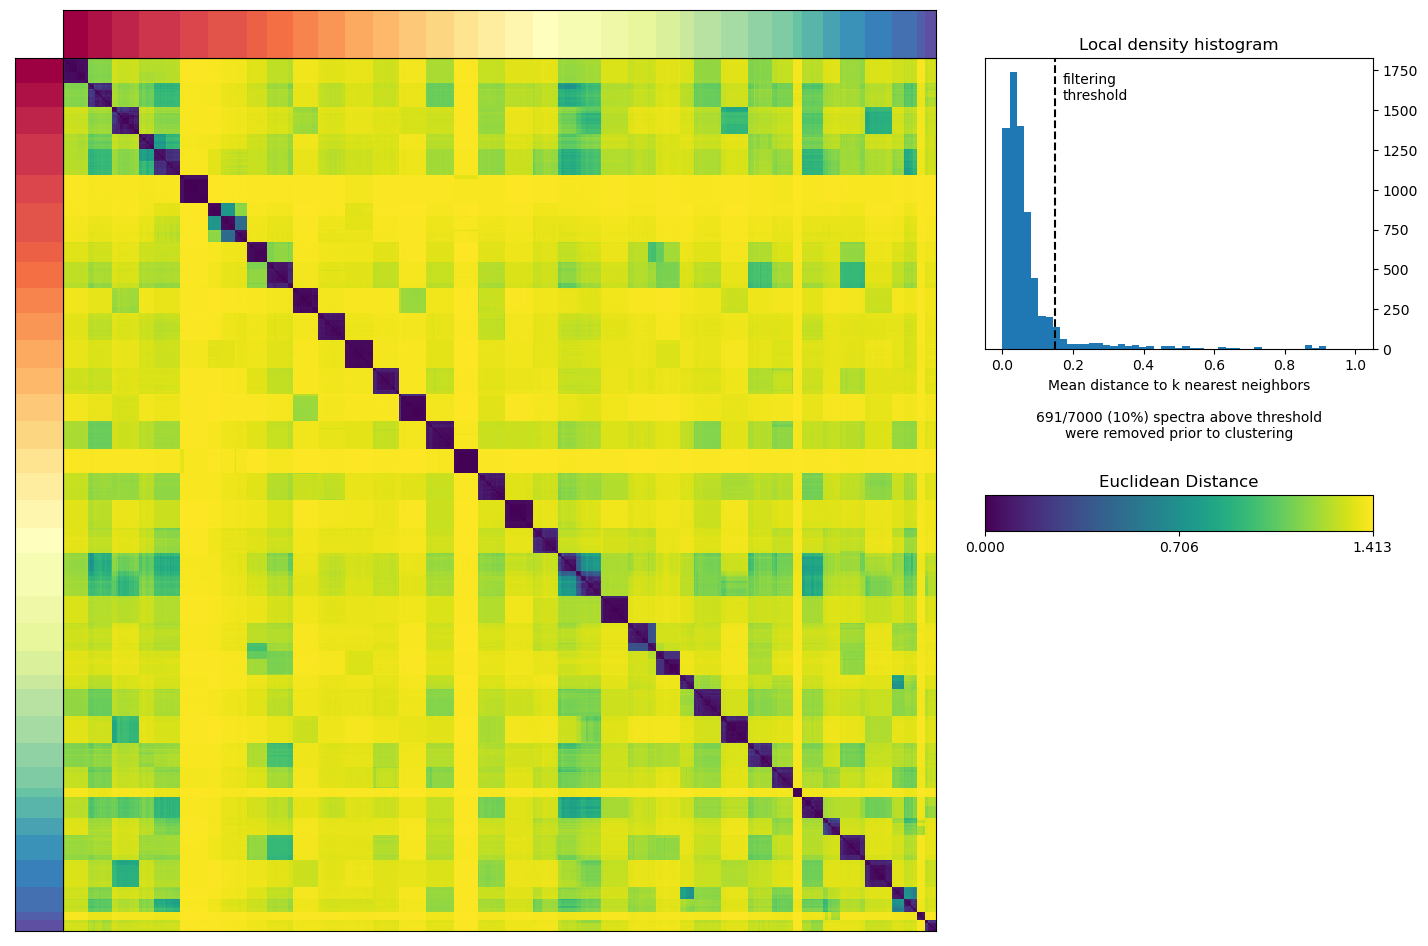

In [80]:
cnmf_obj.consensus(k=35, density_threshold=0.15)

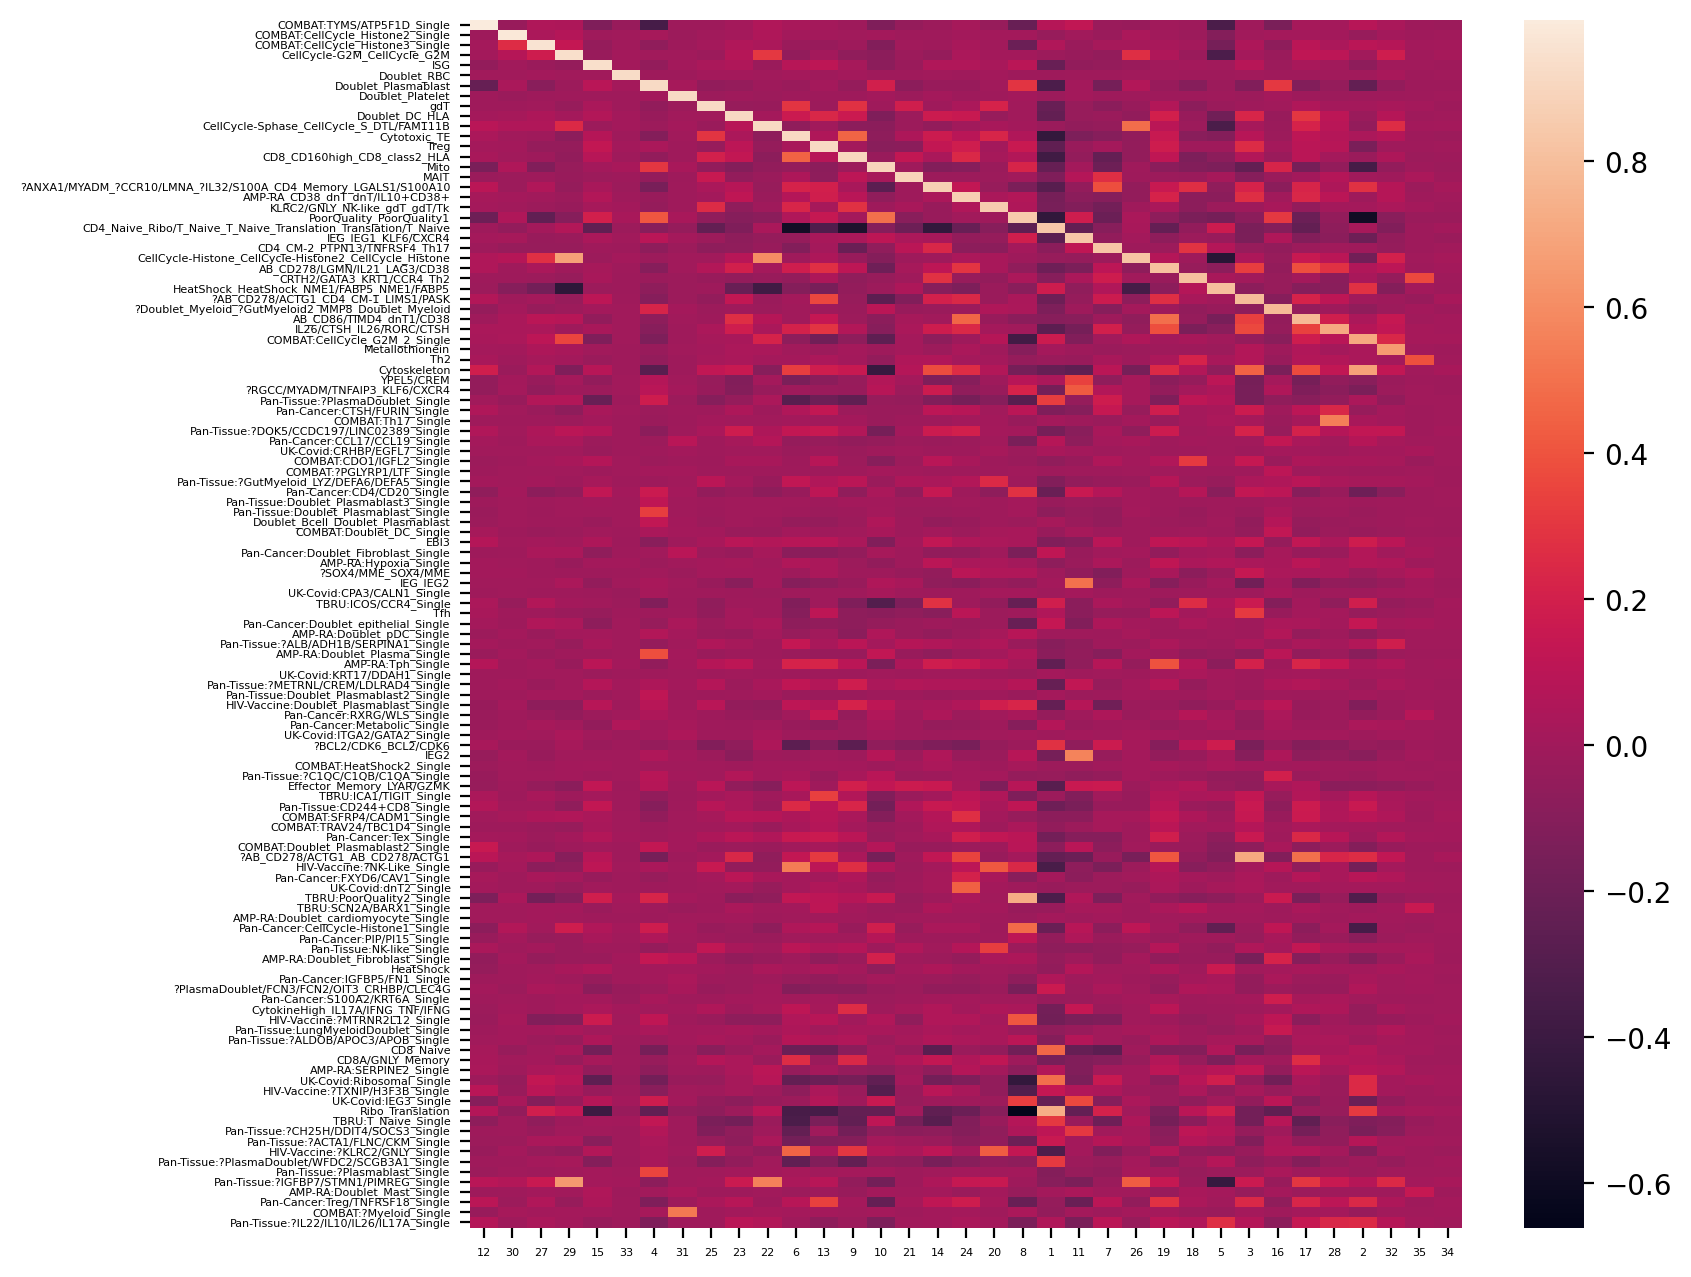

In [66]:
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=35, density_threshold=0.15)
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))

fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
sns.heatmap(R_for_plot, ax=ax)
ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
ax.set_xticklabels(R_for_plot.columns, fontsize=4)
_ = ax.set_yticklabels(R_for_plot.index, fontsize=4)

In [67]:
res = []
k=35
merge_annotation = pd.merge(left=mapping, right=clustering, left_on='X_columns', right_index=True, how='outer')
mapping_ref[k] = merge_annotation
total_overlaps = (merge_annotation['R']>R_thresh).sum()
ind = (merge_annotation['R']>R_thresh) & ((~merge_annotation[dataset_cols].isnull()).sum(axis=1)>1)
nonsingleton_overlaps = ind.sum()
this_dataset_singletons_ind = (~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==0
recur_singleton_ind = this_dataset_singletons_ind & (merge_annotation['R']>R_thresh)
new_singleton_match_ind = ((~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==1) & (merge_annotation['R']>R_thresh) & merge_annotation[this_datset].isnull()
res.append([k, total_overlaps, nonsingleton_overlaps, this_dataset_singletons_ind.sum(), recur_singleton_ind.sum(), (merge_annotation['R']<R_thresh).sum(), new_singleton_match_ind.sum()])

    
    
res = pd.DataFrame(res, columns=['K', 'Num_GEP_Overlaps', 'Num_TCAT_NonSingletonOverlaps', 'Orig_TCAT_Dataset_Singletons', 'TCAT_Singletons_Found', 'New_Singletons', 'Orig_TCAT_OtherDataset_Singleton_Match'])
res

K  Num_GEP_Overlaps  Num_TCAT_NonSingletonOverlaps  \
0  35                33                             29   

   Orig_TCAT_Dataset_Singletons  TCAT_Singletons_Found  New_Singletons  \
0                            13                      4               2   

   Orig_TCAT_OtherDataset_Singleton_Match  
0                                       0

In [51]:
mapping_ref[35]

Y_columns                                      X_columns         R  \
1396.0       12.0                     COMBAT:TYMS/ATP5F1D_Single  0.993890   
3544.0       30.0               COMBAT:CellCycle_Histone2_Single  0.975666   
3183.0       27.0               COMBAT:CellCycle_Histone3_Single  0.961106   
3332.0       29.0                    CellCycle-G2M_CellCycle_G2M  0.939222   
1668.0       15.0                                            ISG  0.938854   
...           ...                                            ...       ...   
NaN           NaN  Pan-Tissue:?GutMyeloid_LYZ/DEFA6/DEFA5_Single       NaN   
NaN           NaN                 Pan-Tissue:?Plasmablast_Single       NaN   
NaN           NaN          Pan-Tissue:Doublet_Plasmablast_Single       NaN   
NaN           NaN         Pan-Tissue:Doublet_Plasmablast2_Single       NaN   
NaN           NaN         Pan-Tissue:Doublet_Plasmablast3_Single       NaN   

                      AMP-RA                UK-Covid  \
1396.0                   NaN                     NaN   
3544.0                   NaN                     NaN   
3183.0                   NaN                     NaN   
3332.0  AMP-RA:CellCycle-G2M  UK-Covid:CellCycle_G2M   
1668.0            AMP-RA:ISG            UK-Covid:ISG   
...                      ...                     ...   
NaN                      NaN                     NaN   
NaN                      NaN                     NaN   
NaN                      NaN                     NaN   
NaN                      NaN                     NaN   
NaN                      NaN                     NaN   

                                    Pan-Tissue                HIV-Vaccine  \
1396.0                                     NaN                        NaN   
3544.0                                     NaN                        NaN   
3183.0                                     NaN                        NaN   
3332.0                Pan-Tissue:CellCycle-G2M  HIV-Vaccine:CellCycle_G2M   
1668.0                          Pan-Tissue:ISG            HIV-Vaccine:ISG   
...                                        ...                        ...   
NaN     Pan-Tissue:?GutMyeloid_LYZ/DEFA6/DEFA5                        NaN   
NaN                    Pan-Tissue:?Plasmablast                        NaN   
NaN             Pan-Tissue:Doublet_Plasmablast                        NaN   
NaN            Pan-Tissue:Doublet_Plasmablast2                        NaN   
NaN            Pan-Tissue:Doublet_Plasmablast3                        NaN   

                           COMBAT                TBRU  \
1396.0        COMBAT:TYMS/ATP5F1D                 NaN   
3544.0  COMBAT:CellCycle_Histone2                 NaN   
3183.0  COMBAT:CellCycle_Histone3                 NaN   
3332.0       COMBAT:CellCycle_G2M  TBRU:CellCycle_G2M   
1668.0                 COMBAT:ISG            TBRU:ISG   
...                           ...                 ...   
NaN                           NaN                 NaN   
NaN                           NaN                 NaN   
NaN                           NaN                 NaN   
NaN                           NaN                 NaN   
NaN                           NaN                 NaN   

                      Pan-Cancer  
1396.0                       NaN  
3544.0                       NaN  
3183.0                       NaN  
3332.0  Pan-Cancer:CellCycle-G2M  
1668.0            Pan-Cancer:ISG  
...                          ...  
NaN                          NaN  
NaN                          NaN  
NaN                          NaN  
NaN                          NaN  
NaN                          NaN  

[119 rows x 10 columns]

In [42]:
os.path.abspath(cnmfdir)

'/data/srlab1/TCAT/Data/PerDataset/COMBAT'

In [43]:
name

'COMBAT.20230927.Iter200'

In [44]:
os.path.abspath('.')

'/data/srlab1/TCAT/Analysis/PerDataset/COMBAT'

In [68]:
gep_info = read_dataset_log('GEP_Name')
gep_info.index = gep_info['MetaGep_Name']
gep_info.head()

MetaGep_Name  \
MetaGep_Name                                                                         
CellCycle-G2M_CellCycle_G2M                            CellCycle-G2M_CellCycle_G2M   
ISG                                                                            ISG   
gdT                                                                            gdT   
Metallothionein                                                    Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  CellCycle-Sphase_CellCycle_S_DTL/FAM111B   

                                                            Long_Name  \
MetaGep_Name                                                            
CellCycle-G2M_CellCycle_G2M                      Cell Cycle G2M Phase   
ISG                                       Interferon Stimulated Genes   
gdT                                               Gamma Delta T Blood   
Metallothionein                                       Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B           Cell Cycle S Phase   

                                               Short_Name Needs Review  \
MetaGep_Name                                                             
CellCycle-G2M_CellCycle_G2M                 CellCycle-G2M          NaN   
ISG                                                   ISG          NaN   
gdT                                             gdT-Blood          NaN   
Metallothionein                           Metallothionein          NaN   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B      CellCycle-S          NaN   

                                                   Class  Num_Datasets Flag  
MetaGep_Name                                                                 
CellCycle-G2M_CellCycle_G2M               Known Activity           7.0  NaN  
ISG                                       Known Activity           7.0  NaN  
gdT                                        Known Lineage           4.0  NaN  
Metallothionein                           Known Activity           5.0  NaN  
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  Known Activity           7.0  NaN

In [69]:
gep2meta = dict(zip(mapping['Y_columns'], mapping['X_columns']))
meta2rename = dict(zip(gep_info['MetaGep_Name'], gep_info['Short_Name']))
# meta2rename['HIV-Vaccine:?TXNIP/H3F3B_Single'] = 'HIV-Vaccine:?TXNIP/H3F3B_Single'
for key in set(gep2meta.values()).difference(meta2rename.keys()):
    meta2rename[key] = key
gep2rename = {g:meta2rename[gep2meta[g]] for g in gep2meta.keys()}

In [70]:
usage_rename = usage.rename(columns=gep2rename)
spectra_scores_rename = spectra_scores.rename(columns=gep2rename)
spectra_tpm_rename = spectra_tpm.rename(columns=gep2rename)

In [48]:
for dat, lab in [(usage_rename, 'Usage'), (spectra_scores_rename, 'Spectra_Scores'), (spectra_tpm_rename, 'Spectra_TPM')]:
    fn = os.path.join(cnmfdir, name +'.'+lab+'.Relabeled.tsv')
    print(os.path.abspath(fn))
    dat.to_csv(fn, sep='\t')

/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBAT.20230927.Iter200.Usage.Relabeled.tsv
/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBAT.20230927.Iter200.Spectra_Scores.Relabeled.tsv
/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBAT.20230927.Iter200.Spectra_TPM.Relabeled.tsv


In [71]:
top_genes_relabed = {}
for g in spectra_scores_rename.columns:
    top_genes_relabed[g] = spectra_scores_rename[g].sort_values(ascending=False).iloc[:50].index
    
top_genes_relabed = pd.DataFrame.from_dict(top_genes_relabed).T

In [50]:
top_genes_relabed

0             1           2   \
CD4-Naive                             RPS12         RPL32       RPS13   
COMBAT:CellCycle_G2M_2_Single          ACTB         HMGN2       ACTG1   
CD4 TCM                            AB_CD278         LIMS1    AB_CD279   
Doublet-Plasma                     IGKV3-20        JCHAIN    IGLV2-14   
HeatShock2                            FABP5      HSP90AB1       HSPD1   
Cytotoxic                            FGFBP2          GZMH        NKG7   
Th17                                   CCR6          CTSH       CMTM6   
MALAT1                                 MYH9          LCP1      HNRNPU   
CD8_EM                                 CMC1          XCL2    AB_CD244   
Mito                                 MT-CYB       MT-ATP6      MT-CO3   
IEG                                     FOS           JUN    PPP1R15A   
COMBAT:TYMS/ATP5F1D_Single          ATP5F1D          TYMS       COTL1   
Treg                                  FOXP3       AB_CD25     AB_CD39   
S100A10/LMNA                          CCR10          LMNA     S100A10   
ISG                                     MX1         ISG15       IFIT3   
Doublet-Myeloid                      S100A8        S100A9     S100A12   
TIMD4/CD38                          AB_CD86         TIMD4        GZMB   
Th2                                  PTGDR2          NEFL        KRT1   
CTLA4+CD38+                        AB_CD278          LGMN        IL21   
gdT                                  SH2D1B       AB_CD16      TYROBP   
MAIT                                SLC4A10  AB_TCR-V-7.2       KLRB1   
CellCycle-S                           UHRF1         GINS2         DTL   
HLA                               AB_HLA-DR       HLA-DRA    HLA-DRB5   
IL10/CD38                             FXYD2          CAV1       PTPN3   
gdT-Blood                             TRDV2         TRGV9  AB_TCR-Vd2   
CellCycle-Histone                      H4C3          RRM2      PKMYT1   
COMBAT:CellCycle_Histone3_Single       H1-5        H2AC13      H2AC12   
IL26/CTSH                              IL26         IL17A        IL22   
CellCycle-G2M                          PLK1         UBE2C       CDC20   
COMBAT:CellCycle_Histone2_Single      H2BC9         H2BC7      H2BC17   
Doublet-Platelet                       PPBP          MYL9         PF4   
Metallothionein                        MT1G          MT1H        MT1E   
Doublet-RBC                             HBB          HBA2        HBA1   
Cytoskeleton                        TRBV5-3       TRBV5-7     TRBV5-4   
CCR3+-Th2                             GAP43         SCN2A        GJA1   

                                             3           4           5   \
CD4-Naive                                 RPS3A        RPS8       RPL30   
COMBAT:CellCycle_G2M_2_Single              CFL1        PFN1       PTTG1   
CD4 TCM                                  TMSB4X        UCP2       ACTG1   
Doublet-Plasma                         IGLV1-44    IGLV3-21     IGLV3-1   
HeatShock2                                HSPE1        NPM1     AB_CD71   
Cytotoxic                               AB_CD57        GZMB      ADGRG1   
Th17                                       AQP3      AB_CD2     AB_CD28   
MALAT1                                    AHNAK       MKI67       PTPRC   
CD8_EM                            AB_KLRG1_MAFA        CCL5        GZMK   
Mito                                    MT-ND4L      MT-CO2      MT-ND5   
IEG                                       DUSP1       ZFP36        JUNB   
COMBAT:TYMS/ATP5F1D_Single                 SLBP     PRELID1     C4orf48   
Treg                                      RTKN2     AB_CD95       IL2RA   
S100A10/LMNA                           AB_CD194        AIRE        PI16   
ISG                                       IFIT1        IFI6        OAS1   
Doublet-Myeloid                             LYZ  AB_CLEC12A     AB_CD35   
TIMD4/CD38                            AB_CD38-1    AB_CD49b        GZMA   
Th2                                         ZP1        CDO1   

In [85]:
spectra_scores.loc[:, 34].sort_values(ascending = False).head(30)

TRBV5-3      0.137252
TRBV5-7      0.131363
TRBV5-4      0.022599
TRAV6        0.004243
CKMT2        0.004178
TP73         0.004138
DHRS2        0.003763
SYT4         0.003474
TRAV23DV6    0.003151
PLCH1        0.003142
SFRP4        0.003138
CTF1         0.002999
TMEM31       0.002784
GLDN         0.002591
PSMA8        0.002575
TRGV1        0.002486
KCNE5        0.002281
PLK5         0.002176
CIB3         0.002150
CAPN9        0.002129
COL4A5       0.002069
TNC          0.002057
TRBV5-6      0.001962
MUC16        0.001902
HMX2         0.001894
ACTG1        0.001869
TRGV3        0.001853
LRRC75B      0.001833
IGHV1-45     0.001697
MKI67        0.001688
Name: 34, dtype: float64

In [86]:
spectra_scores.loc[:, 2].sort_values(ascending = False).head(30)

ACTB       0.002904
HMGN2      0.002405
ACTG1      0.002321
CFL1       0.001993
PFN1       0.001936
PTTG1      0.001918
GAPDH      0.001727
MYL6       0.001564
CORO1A     0.001505
ARHGDIB    0.001401
ARPC2      0.001348
TMSB10     0.001342
PSME2      0.001332
TUBA1B     0.001295
CNN2       0.001292
BIRC5      0.001270
COX8A      0.001269
CDKN3      0.001224
CHCHD2     0.001221
PPIA       0.001218
CDC20      0.001215
CDK2AP2    0.001182
H2AZ1      0.001148
ARPC5      0.001132
CALM1      0.001127
CCNB2      0.001120
TPM3       0.001094
CAP1       0.001092
SLC25A5    0.001089
STMN1      0.001062
Name: 2, dtype: float64

In [73]:
mapping[mapping['X_columns']=='Cytoskeleton']

Y_columns     X_columns         R
3931         34  Cytoskeleton  0.029377

In [74]:
mapping[mapping['X_columns']=='COMBAT:CellCycle_G2M_2_Single']

Y_columns                      X_columns         R
207          2  COMBAT:CellCycle_G2M_2_Single  0.703831

In [61]:
tcat_spectra_all['Cytoskeleton'].sort_values(ascending = False).head(20)

ACTB        0.011078
ACTG1       0.008872
PFN1        0.008421
CFL1        0.007106
CORO1A      0.006781
MYL6        0.006164
ARPC1B      0.005697
CLIC1       0.005528
SH3BGRL3    0.005053
S100A4      0.004976
TMSB4X      0.004958
TMSB10      0.004933
ARPC2       0.004928
TPM4        0.004707
LCP1        0.004474
MYL12A      0.004403
PSME2       0.004390
IL32        0.004330
RAC2        0.004249
CNN2        0.004196
Name: Cytoskeleton, dtype: float64

In [62]:
tcat_spectra_all['COMBAT:CellCycle_G2M_2_Single'].sort_values(ascending = False).head(20)

CDC20      0.003251
CCNB2      0.003225
PTTG1      0.003023
HMGN2      0.002951
BIRC5      0.002879
CDKN3      0.002691
TUBA1B     0.002675
HMGB2      0.002667
STMN1      0.002535
H2AZ1      0.002378
CCNB1      0.002013
CENPW      0.001872
HMGB3      0.001778
DLGAP5     0.001711
TROAP      0.001679
HMGB1      0.001637
AB_CD71    0.001598
GAPDH      0.001567
TUBB       0.001459
DEPDC1B    0.001435
Name: COMBAT:CellCycle_G2M_2_Single, dtype: float64